In [1]:
import sys
import os

sys.path.insert(0, '/home/caron/Bureau/Model/HexagonalScale/ST-GNN-for-wildifre-prediction/Prediction')

from tools import *
from config import *

/home/caron/Bureau/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Nom de l'hôte : caron-Precision-7780
Adresse IP locale : 127.0.1.1


/home/caron/Bureau/.conda/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Nom de l'hôte : caron-Precision-7780
Adresse IP locale : 127.0.1.1


In [2]:
def order_class(predictor, pred):
    res = np.zeros(pred[~np.isnan(pred)].shape[0], dtype=int)
    cc = predictor.cluster_centers.reshape(-1)
    classes = np.arange(cc.shape[0])
    ind = np.lexsort([cc])
    cc = cc[ind]
    classes = classes[ind]
    for c in range(cc.shape[0]):
        mask = np.argwhere(pred == classes[c])
        res[mask] = c
    return res

def class_risk(ypred, ytrue, ybin, nameDep : str, predictor) -> dict:
    if torch.is_tensor(ypred):
        ypred = ypred.detach().cpu().numpy().astype(float)
    if torch.is_tensor(ytrue):
        ytrue = ytrue.detach().cpu().numpy().astype(float)

    res = {}

    yclass = predictor.predict(ytrue)
    yclass = order_class(predictor, yclass)
    uniqueClass = np.unique(yclass)
    res[nameDep] = {}
    for c in uniqueClass:
        classIndex = np.argwhere(yclass == c)
        classPred = ypred[classIndex]
        classTrue = ypred[classIndex]
        error = abs(classPred - classTrue)
        classBin = ybin[classIndex]
        meanF = round(np.mean(classBin), 3)
        print(c, np.nansum(classBin), np.nansum(ybin))
        meanFF = round(100 * (np.nansum(classBin) / np.nansum(ybin)))
        meanP = round(np.mean(classPred), 3)
        meanT = round(np.mean(classTrue), 3)
        error = round(np.mean(error))
        res[nameDep][c] = (round(predictor.get_centroid(c)[0], 3), meanP, meanT, error, meanFF, meanF)
        
    return res[nameDep]

def get_max(influence):
    return np.nanmax(influence)

def get_sum(influence):
    return np.nansum(influence)

In [3]:
allMonth = [date.split('-')[1] for date in allDates]


def analyse_target(scales, exps, name_exp, test):
    classs = {}
    f1s = {}
    means = {}
    means2 = {}
    for ni, scale in enumerate(scales):
        classs[scale] = {}
        p = Path(exps[ni] + '/' + name_exp+'/train/')
        print(p)
        Y = read_object('Y_full_'+scale+'.pkl', p)
        print(np.min(Y[:, -1]), np.max(Y[:, -1]))
        Y_month = [allMonth[int(di)] for di in Y[:,4]]
        graph = read_object('graph_'+scale+'.pkl', p)
        print(scale, Y[Y[:,-2] > 0].shape, Y[(Y[:,-3] > 0) & (Y[:,-2] > 0)].shape)
        print(np.unique(Y[:,4]).shape, (allDates.index('2023-01-01')))
        departements = ['departement-01-ain',
                        'departement-25-doubs',
                        'departement-78-yvelines',
                        'departement-69-rhone'
                        ]
        bins = []
        influences = []
        mean = []
        mean2 = []
        for dep in departements:
            classs[scale][dep] = {}
            dir_predictor = p / 'influenceClustering'
            predictor = read_object(dep+'Predictor'+scale+'.pkl', dir_predictor)
            bin = Y[Y[:,3] == name2int[dep]][:,-2]
            influence = Y[Y[:,3] == name2int[dep]][:,-1]

            bins += list(bin[~np.isnan(bin)])
            influences += list(influence[~np.isnan(bin)])
            print(influence[~np.isnan(bin)].shape)
            classs[scale][dep]['class'] = class_risk(influence[~np.isnan(bin)], influence[~np.isnan(bin)], bin[~np.isnan(bin)] > 0, dep, predictor)
            Y2 = np.empty((influence[~np.isnan(bin)].shape[0], 8))
            Y2[:, -2] = bin[~np.isnan(bin)]
            Y2[:, -1] = influence
            Y2[:, 3] = name2int[dep]
            classss = predictor.predict(influence[~np.isnan(bin)]).reshape(-1,1).astype(int)
            classs[scale][dep]['weighted_f1'] = my_f1_score(Y2, influence[~np.isnan(bin)], False, predictor.weight_array(classss).reshape(-1))
            classs[scale][dep]['non_weighted_f1'] = my_f1_score(Y2, influence[~np.isnan(bin)], False, None)
            if len(mean) == 0:
                for c in [0,1,2,3,4]:
                    mean.append(classs[scale][dep]['class'][c][-1])
                    mean2.append(classs[scale][dep]['class'][c][-2])
                f1s['weighted_f1'] = classs[scale][dep]['weighted_f1'][0]
                f1s['non_weighted_f1'] = classs[scale][dep]['non_weighted_f1'][0]
            else:
                for c in [0,1,2,3,4]:
                    mean[c] += classs[scale][dep]['class'][c][-1]
                    mean2[c] += classs[scale][dep]['class'][c][-2]
                f1s['weighted_f1'] += classs[scale][dep]['weighted_f1'][0]
                f1s['non_weighted_f1'] += classs[scale][dep]['non_weighted_f1'][0]

        mean = np.asarray(mean) / len(departements)
        mean2 = np.asarray(mean2) / len(departements)
        f1s['weighted_f1'] = f1s['weighted_f1']  / len(departements)
        f1s['non_weighted_f1'] = f1s['non_weighted_f1']  / len(departements)

        means[scale] = mean
        means2[scale] = mean2

    return classs, f1s, means, means2

scales = ['10']
exps = ['final']
name_exp = 'firepoint/2x2/'
test = "2023"
classs, f1s, means, means2 = analyse_target(scales, exps, name_exp, test)

final/firepoint/2x2/train
1.4491524993887062e-10 43.61857362475375
10 (7191, 9) (7191, 9)
(2573,) 2029
(52162,)
0 0 2516
1 288 2516
2 1305 2516
3 716 2516
4 207 2516
(51460,)
0 0 1890
1 1086 1890
2 542 1890
3 214 1890
4 48 1890
(23157,)
0 0 1983
1 827 1983
2 651 1983
3 384 1983
4 121 1983
(15153,)
0 0 802
1 206 802
2 438 802
3 139 802
4 19 802


In [21]:
classs

{'10': {'departement-01-ain': {'class': {0: (0.077, 0.044, 0.044, 0, 0, 0.0),
    1: (6.347, 1.743, 1.743, 0, 11, 0.039),
    2: (1.744, 3.588, 3.588, 0, 52, 0.369),
    3: (11.264, 6.343, 6.343, 0, 28, 0.529),
    4: (3.594, 11.209, 11.209, 0, 8, 0.699)},
   'weighted_f1': (0.7755934415531447,
    0.6394512072096308,
    0.9853870867447404,
    0.9,
    17.508282544128498),
   'non_weighted_f1': (0.4870862827625789,
    0.46956842493544815,
    0.5059618441971383,
    0.9,
    17.508282544128498)},
  'departement-25-doubs': {'class': {0: (0.072, 0.033, 0.033, 0, 0, 0.0),
    1: (11.084, 2.285, 2.285, 0, 57, 0.234),
    2: (2.314, 5.294, 5.294, 0, 29, 0.519),
    3: (22.097, 11.114, 11.114, 0, 11, 0.767),
    4: (5.31, 21.987, 21.987, 0, 3, 0.873)},
   'weighted_f1': (0.6379703534777651,
    0.8528963414634146,
    0.5095628415300546,
    0.9,
    33.99032057266008),
   'non_weighted_f1': (0.49542961608775143,
    0.584051724137931,
    0.4301587301587302,
    0.9,
    33.9903205726600

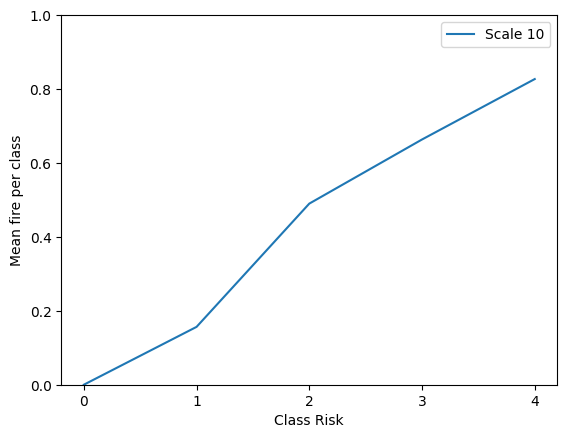

In [22]:
for sc in scales:
    plt.plot(np.arange(5), means[sc],label='Scale ' + sc)

plt.xticks([0,1,2,3,4])
plt.ylim(0, 1)
plt.ylabel('Mean fire per class')
plt.xlabel('Class Risk')
plt.legend()

In [17]:
means[sc]

array([0.    , 0.1565, 0.49  , 0.6635, 0.827 ])

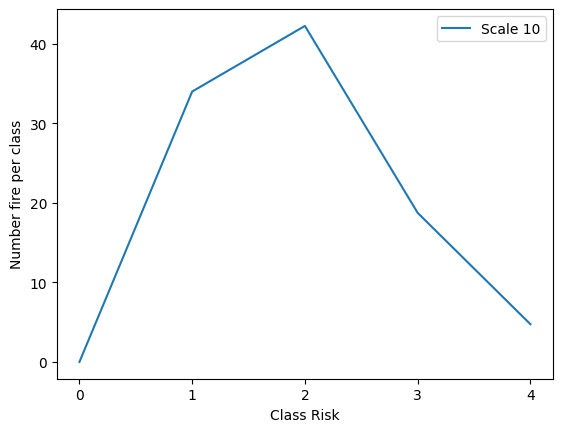

In [16]:
for sc in scales:
    plt.plot(np.arange(5), means2[sc],label='Scale ' + sc)

plt.xticks([0,1,2,3,4])
plt.ylabel('Number fire per class')
plt.xlabel('Class Risk')
plt.legend()

In [13]:
x = read_object('Y_binary_7_departement_None.pkl', Path('/home/caron/Bureau/Model/HexagonalScale/ST-GNN-for-wildifre-prediction/Prediction/GNN/bdiff/firepoint/2x2/train'))

In [23]:
x.shape

(331426, 9)

In [14]:
np.unique(x[:, 3])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
       54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.,
       67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79.,
       80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 93.,
       94.])

In [15]:
np.unique(x[:, 0])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 91.,
       92.])

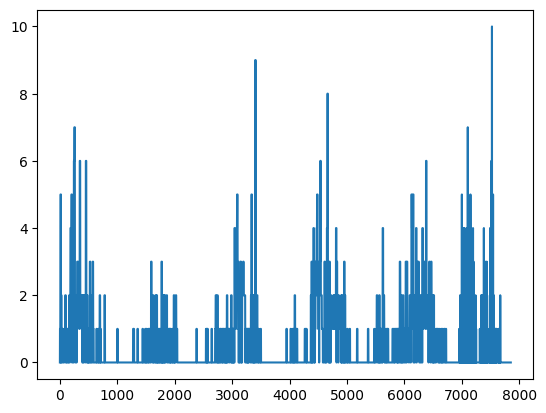

In [20]:
plt.plot(x[x[:, 3] == 13, -2])

In [22]:
np.unique(x, axis=0).shape

(273135, 9)

In [12]:
np.sum(x[:, -2])

12884.0

In [2]:
name_exp = 'firemen'
sinister = 'firepoint'
test = 'occurence_test_geometry'
#iremen/firepoint/2x2/train/df_binary-100_7_8_risk-watershed.pkl
df = read_object('df_train_full_0_4_risk-size-watershed_graph_None.pkl', Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'train' + '/occurence_test_geometry'))
df2 = read_object('df_train_full_0_4_risk-size-watershed_node_None.pkl', Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'train' + '/occurence_test_geometry'))
Y = read_object('X_full_4_risk-size-watershed_graph.pkl', Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'train' + '/'))

#graph = read_object('00.pkl', Path(name_exp + '/' + sinister + '/' + '2x2/train'))
#features = read_object('features_importance.pkl', Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'train' + '/default/' + 'full_7_3_geometry-risk'))
print(df.shape)
features_name, _ = get_features_name_list(10, features, METHODS_SPATIAL)
Y_by_date = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))

Y_by_date = np.asarray(Y_by_date)
plt.plot(Y_by_date)
print(np.sum(Y[:, -2]))

2024-11-14 17:54:57,219 [INFO ]  firemen/firepoint/2x2/train/occurence_test_geometry/df_train_full_0_4_risk-size-watershed_graph_None.pkl not found
2024-11-14 17:54:57,219 [INFO ]  firemen/firepoint/2x2/train/occurence_test_geometry/df_train_full_0_4_risk-size-watershed_graph_None.pkl not found


AttributeError: 'NoneType' object has no attribute 'shape'

<Axes: >

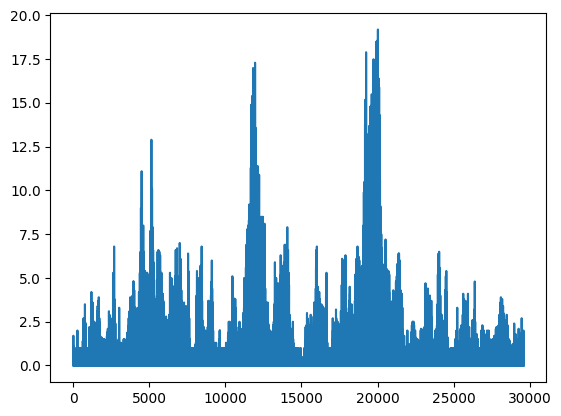

In [11]:
df2.reset_index()['risk'].plot()

<Axes: >

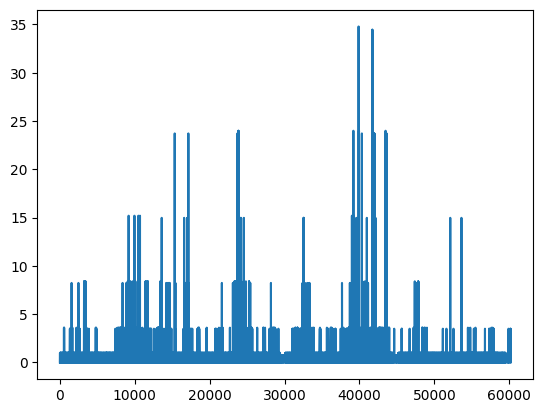

In [125]:
df['weight_outlier_nbsinister'].reset_index(drop=True).plot()

<Axes: >

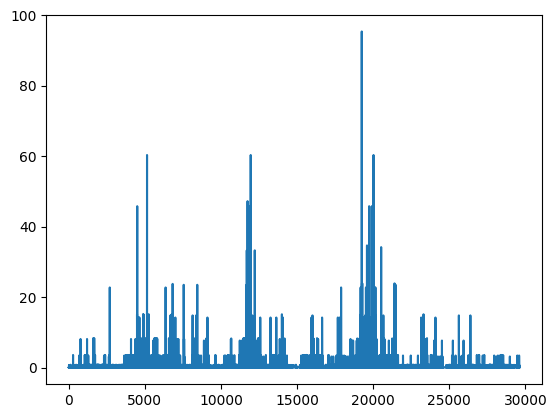

In [126]:
df2['weight_outlier_nbsinister'].reset_index(drop=True).plot()

<Axes: >

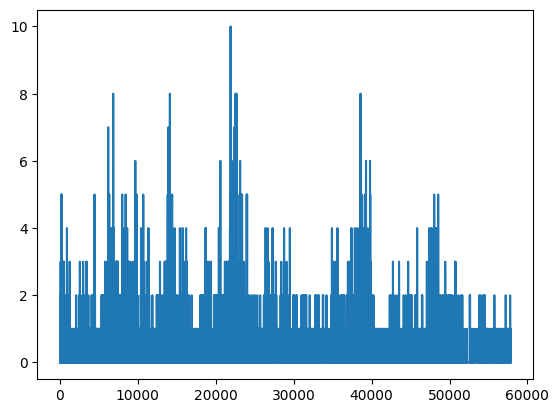

In [72]:
df2.groupby(['date', 'graph_id'])['nbsinister'].mean().reset_index(drop=True).plot()

<Axes: >

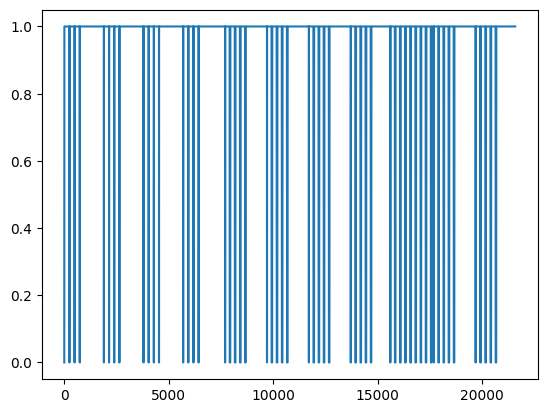

In [50]:
df['weight'].reset_index(drop=True).plot()

<Axes: >

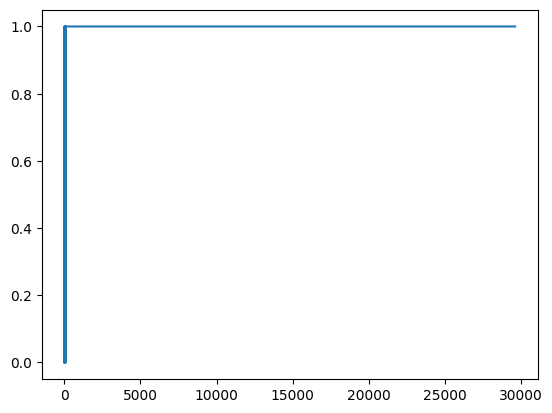

In [43]:
df2['weight_outlier_nbsinister'].reset_index(drop=True).plot()

In [34]:
Y[:, 11]

array([  0.   ,   0.   ,   8.815, ..., 158.48 , 161.718, 156.074])

In [24]:
df['secondary_mean'].unique()

array([12.602, 18.783, 10.612, 24.895,  8.378,  5.377, 21.378, 11.271,
       44.248, 28.735, 20.223, 19.974])

In [20]:
for col in df.columns:
    print(col)

dwpt_max
rhum_mean
rhum_min
prcp_max
wdir_mean
wdir_min
wdir_max
wspd_mean
wspd_min
prec24h_mean
prec24h_min
ffmc_mean
nesterov_mean
nesterov_min
munger_mean
munger_min
munger_max
kbdi_mean
kbdi_min
angstroem_mean
bui_max
fwi_min
fwi_max
temp16_mean
rhum16_mean
rhum16_min
prcp16_max
wdir16_mean
wdir16_min
wdir16_max
wspd16_min
wspd16_max
prec24h16_mean
prec24h16_min
days_since_rain_mean
days_since_rain_min
days_since_rain_max
sum_consecutive_rainfall_mean
sum_consecutive_rainfall_min
sum_consecutive_rainfall_max
sum_rain_last_7_days_mean
sum_rain_last_7_days_min
sum_snow_last_7_days_mean
sum_snow_last_7_days_min
sum_snow_last_7_days_max
elevation_min
population_max
foret_encoder_mean
foret_encoder_min
argile_encoder_max
id_encoder_max
cluster_encoder
cosia_encoder_mean
cosia_encoder_min
cosia_encoder_max
12_mean
12_max
Feuillus_mean
Hêtre_mean
Hêtre_max
Mélèze_max
Mixtes_max
NC_mean
NC_max
Pin autre_max
Pin maritime_max
Pin sylvestre_max
Peuplier_max
Sapin, épicéa_mean
PasDeRoute_mean


In [27]:
df['dwpt_max'].values

array([ 0.   ,  0.746,  6.274, ..., 15.929, 18.209, 20.307])

In [17]:
df5 = df[df['id'] == 5]

KeyError: 'pastinfluence'

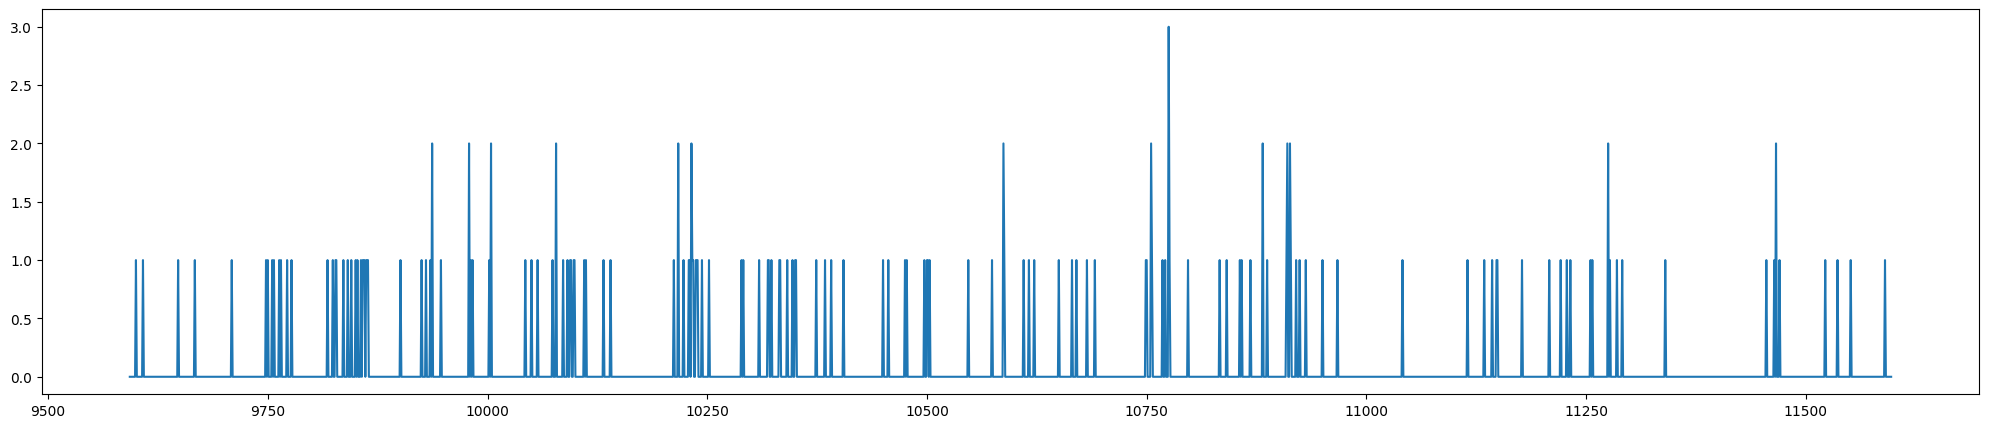

In [16]:
fig, ax = plt.subplots(1, figsize=(25,5))
df5['nbsinister_id'].plot(ax=ax)
df5['pastinfluence'].plot(ax=ax)

In [13]:
df5[df5['pastinfluence'] > 0][['pastinfluence', 'nbsinister']]

,pastinfluence,nbsinister
9495,0.333,0.0
9496,0.111,0.0
9536,0.333,0.0
9537,0.111,0.0
9539,0.333,0.0
...,...,...
11075,0.111,0.0
11090,0.333,0.0
11091,0.111,0.0
11237,0.333,0.0


In [22]:
df.columns

Index(['dwpt_mean', 'rhum_mean', 'prcp_max', 'wdir_mean', 'wdir_min',
       'wdir_max', 'wspd_mean', 'wspd_min', 'prec24h_mean', 'prec24h_min',
       ...
       'weight_random', 'weight_outlier',
       'weight_proportion_on_zero_class_nbsinister', 'weight_class_nbsinister',
       'weight_proportion_on_zero_sinister_nbsinister',
       'weight_one_nbsinister', 'weight_normalize_nbsinister',
       'weight_nbsinister_nbsinister', 'weight_random_nbsinister',
       'weight_outlier_nbsinister'],
      dtype='object', length=133)

<Axes: >

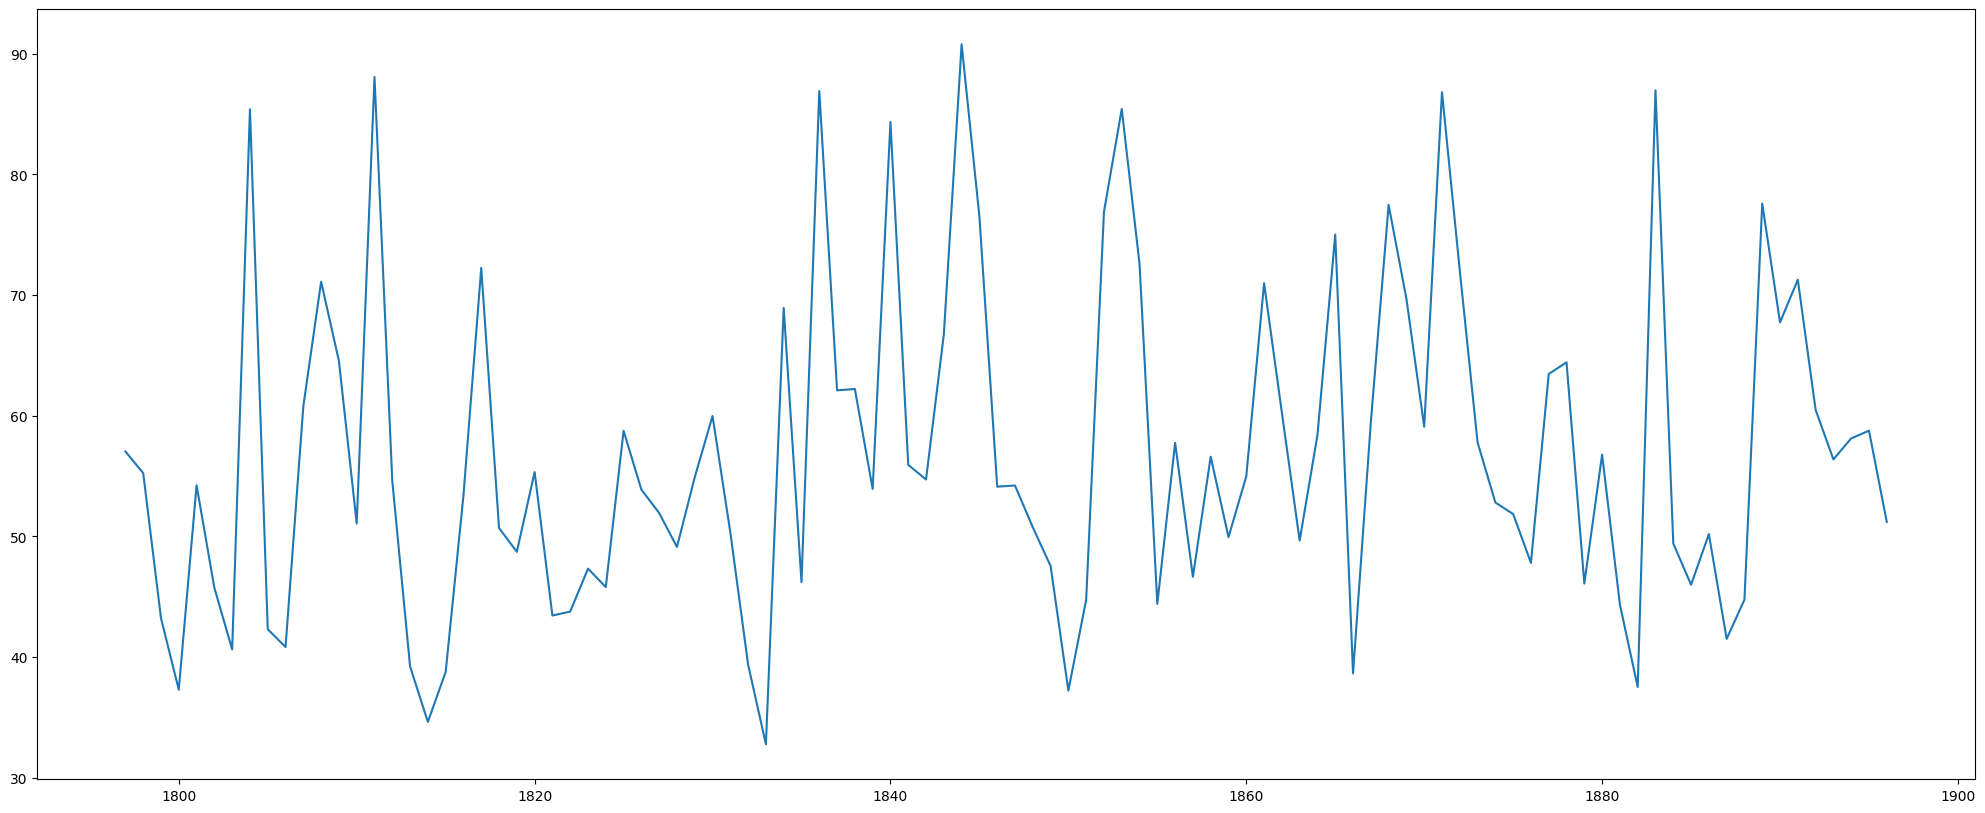

In [24]:
df0 = df[df['id'] == 0]
fig, ax = plt.subplots(1, figsize=(25,10))
df0['rhum_mean'][-100:].plot(ax=ax)

In [31]:
df0['pastinfluence']

KeyError: 'pastinfluence'

In [25]:
df0.columns

Index(['12_mean', '12_min', 'Building_max', 'Chênes décidus_max',
       'Chênes décidus_mean', 'Conifères_mean', 'Crop_max', 'Deciduous_min',
       'Douglas_max', 'Feuillus_max',
       ...
       'weight_proportion_on_zero_class',
       'weight_proportion_on_zero_class_nbsinister',
       'weight_proportion_on_zero_sinister',
       'weight_proportion_on_zero_sinister_nbsinister', 'weight_random',
       'weight_random_nbsinister', 'wspd16_max', 'wspd16_min', 'wspd_max',
       'wspd_min'],
      dtype='object', length=128)

In [5]:
Y.shape

(195224, 10)

In [7]:
np.unique(Y[:, 0]), np.unique(Y[:, 1])

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106.]))

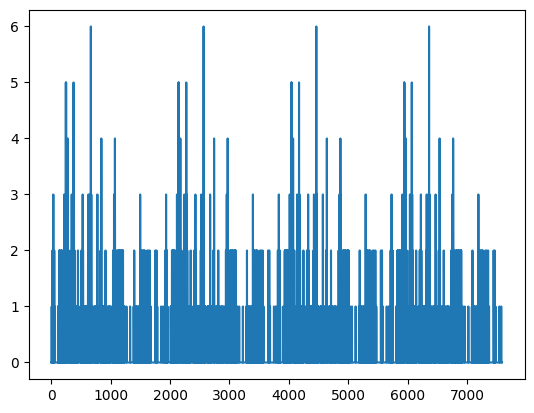

In [9]:
plt.plot(Y[Y[:, 0] == 2][:, -2])

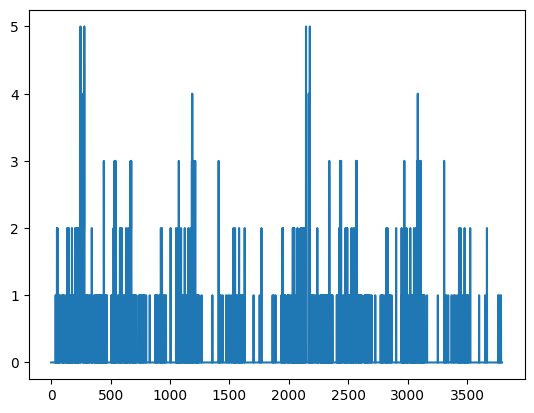

In [11]:
plt.plot(Y[Y[:, 0] == 0][:, -2])

<Axes: >

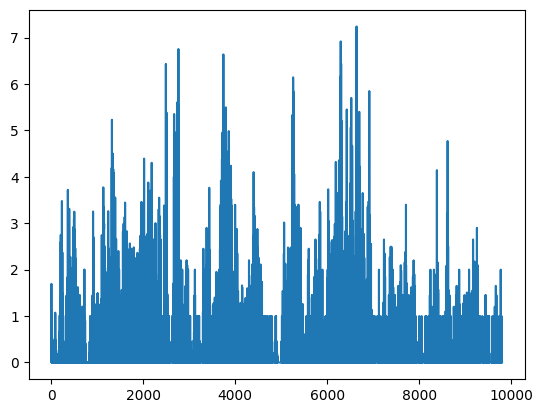

In [7]:
df[df['departement'] == 1].reset_index()['risk'].plot()

<Axes: >

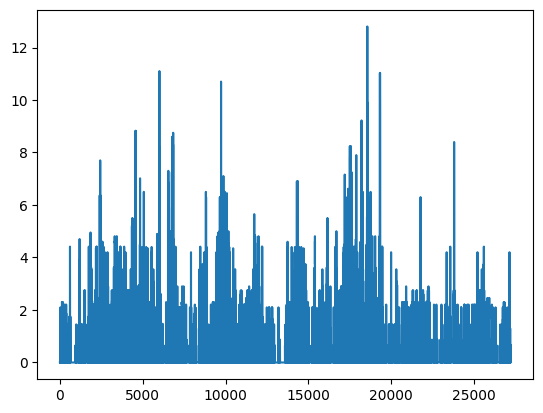

In [8]:
df2[df2['departement'] == 1].reset_index()['risk'].plot()

<Axes: >

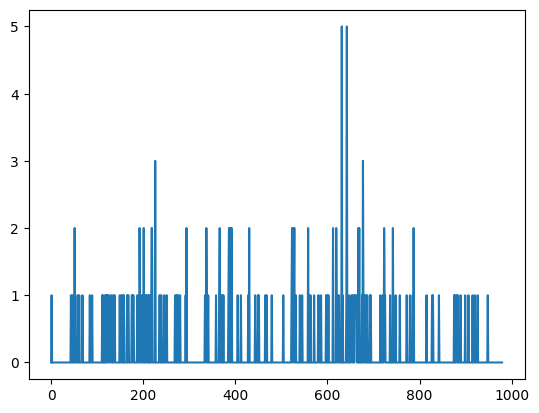

In [17]:
df[df['graph_id'] == 1].reset_index()['nbsinister'].plot()

<Axes: >

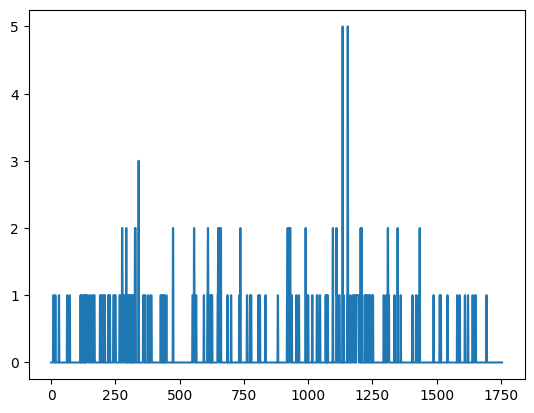

In [16]:
df2[df2['graph_id'] == 1].reset_index()['nbsinister'].plot()

<Axes: >

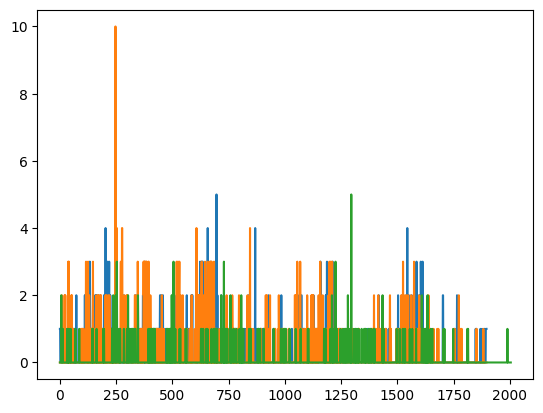

In [9]:
df2[df2['id'] == 0].reset_index()['nbsinister'].plot()
df2[df2['id'] == 1].reset_index()['nbsinister'].plot()
df2[df2['id'] == 14].reset_index()['nbsinister'].plot()

In [28]:
df2[df2['id'] == 0]

,id,longitude,latitude,departement,date,weight,days_until_next_event,class_risk,nbsinister,risk,...,weight_nbsinister,weight_proportion_on_zero_sinister,weight_random,weight_proportion_on_zero_class_nbsinister,weight_class_nbsinister,weight_proportion_on_zero_sinister_nbsinister,weight_one_nbsinister,weight_normalize_nbsinister,weight_nbsinister_nbsinister,weight_random_nbsinister
32,0.0,4.910076,45.969332,1.0,293.0,1.0,0,0.0,1.0,1.013,...,2.0,4.278527,7.178492,1.0,1.0,4.278527,1.0,2.0,2.0,8.420037
33,0.0,4.910076,45.969332,1.0,294.0,1.0,5,0.0,0.0,0.454,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
34,0.0,4.910076,45.969332,1.0,295.0,1.0,4,0.0,0.0,0.200,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
35,0.0,4.910076,45.969332,1.0,296.0,1.0,3,0.0,0.0,0.008,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
36,0.0,4.910076,45.969332,1.0,297.0,1.0,2,0.0,0.0,0.208,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0.0,4.910076,45.969332,1.0,1567.0,1.0,5,0.0,0.0,0.278,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
952,0.0,4.910076,45.969332,1.0,1568.0,1.0,4,0.0,0.0,0.174,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
953,0.0,4.910076,45.969332,1.0,1569.0,1.0,3,0.0,0.0,0.223,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
954,0.0,4.910076,45.969332,1.0,1570.0,1.0,2,0.0,0.0,0.285,...,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000


In [8]:
from tslearn.clustering import TimeSeriesKMeans

df2 = df2[(df2['date'] >= allDates.index('2018-04-01')) & (df2['date'] <= allDates.index('2021-09-30'))]

uids = np.unique(df2.id.values)
vec_target = []
for id in uids:
    print(id)
    vec_target.append(df2[df2['id'] == id]['nbsinister'].values[:900])

print(np.asarray(vec_target).shape)
cluster_node_model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10, random_state=42)

cluster_node_model.fit(np.asarray(vec_target))

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
(15, 900)


TimeSeriesKMeans(max_iter=10, metric='dtw', random_state=42)

In [6]:
array([0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0])

NameError: name 'array' is not defined

In [9]:
cluster_node_model.predict(np.asarray(vec_target))

/home/caron/Bureau/.conda/lib/python3.9/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 15 1-dimensional timeseries
  warnings.warn(


array([0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0])

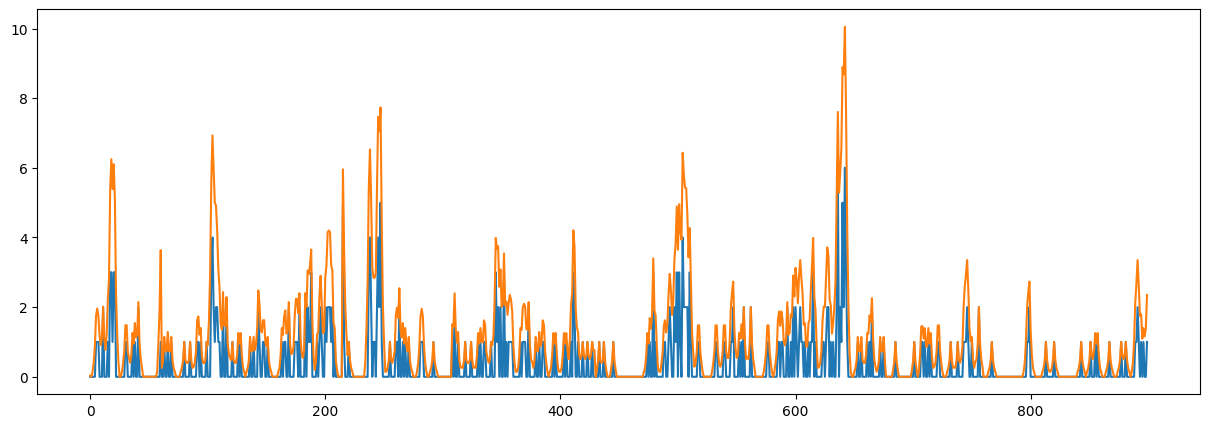

In [76]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(df2[df2['id'] == 5]['nbsinister'].values[:900])
ax.plot(df2[df2['id'] == 5]['risk'].values[:900])
#ax.plot(df2[df2['id'] == 12]['nbsinister'].values[:900])

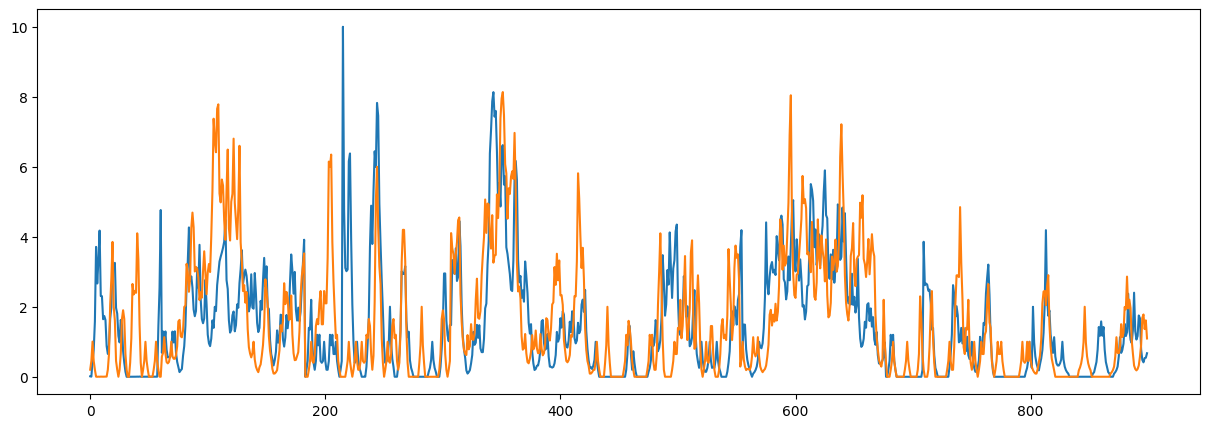

In [68]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(df2[df2['id'] == 1]['risk'].values[:900])
ax.plot(df2[df2['id'] == 9]['risk'].values[:900])

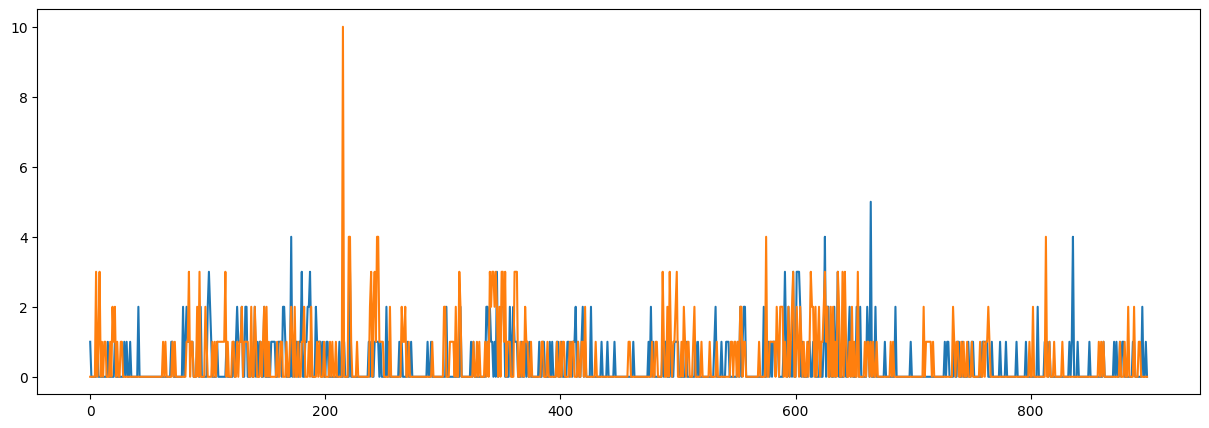

In [42]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(df2[df2['id'] == 0]['nbsinister'].values[:900])
ax.plot(df2[df2['id'] == 1]['nbsinister'].values[:900])

In [7]:
df2[(df2['date'] > allDates.index('2022-01-01')) & (df2['date'] < allDates.index('2023-01-01'))]

,id,longitude,latitude,departement,date,weight,days_until_next_event,class_risk,nbsinister,risk,...,weight_nbsinister,weight_proportion_on_zero_sinister,weight_random,weight_proportion_on_zero_class_nbsinister,weight_class_nbsinister,weight_proportion_on_zero_sinister_nbsinister,weight_one_nbsinister,weight_normalize_nbsinister,weight_nbsinister_nbsinister,weight_random_nbsinister
989,0.0,4.910076,45.969332,1.0,1665.0,1.0,42,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
990,0.0,4.910076,45.969332,1.0,1666.0,1.0,41,0.0,0.0,-0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
991,0.0,4.910076,45.969332,1.0,1667.0,1.0,40,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
992,0.0,4.910076,45.969332,1.0,1668.0,1.0,39,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
993,0.0,4.910076,45.969332,1.0,1669.0,1.0,38,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26836,14.0,1.843619,48.624263,78.0,2024.0,1.0,41,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
26837,14.0,1.843619,48.624263,78.0,2025.0,1.0,40,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
26838,14.0,1.843619,48.624263,78.0,2026.0,1.0,39,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
26839,14.0,1.843619,48.624263,78.0,2027.0,1.0,38,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
df2['year'] = df2['date'].apply(lambda x : allDates[int(x)].split('-')[0])

In [17]:
df2 = df2[df2['departement'] == 1]

In [18]:
df2['nbsinister'].max(), df2['nbsinister'].std(), df2['nbsinister'].mean()

(10.0, 0.5732566534913102, 0.225531541029696)

In [25]:
df2 = df2[df2['id'] == 5]

In [26]:
df2.groupby(['id', 'year'])['nbsinister'].sum()

id   year
5.0  2018    106.0
     2019     98.0
     2020    130.0
     2021     47.0
     2022    133.0
     2023     62.0
     2024      8.0
Name: nbsinister, dtype: float64

In [13]:
df55 = df2[df2['departement'] == 55]
df55

,id,longitude,latitude,departement,date,weight,days_until_next_event,class_risk,nbsinister,risk,...,weight_nbsinister,weight_proportion_on_zero_sinister,weight_random,weight_proportion_on_zero_class_nbsinister,weight_class_nbsinister,weight_proportion_on_zero_sinister_nbsinister,weight_one_nbsinister,weight_normalize_nbsinister,weight_nbsinister_nbsinister,weight_random_nbsinister
271582,453.0,5.145118,49.017200,55.0,2029.0,1.0,-1,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
271583,453.0,5.145118,49.017200,55.0,2030.0,1.0,-1,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
271584,453.0,5.145118,49.017200,55.0,2031.0,1.0,-1,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
271585,453.0,5.145118,49.017200,55.0,2032.0,1.0,-1,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
271586,453.0,5.145118,49.017200,55.0,2033.0,1.0,-1,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276473,461.0,5.141261,48.836072,55.0,2568.0,1.0,-1,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
276474,461.0,5.141261,48.836072,55.0,2569.0,1.0,-1,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
276475,461.0,5.141261,48.836072,55.0,2570.0,1.0,-1,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
276476,461.0,5.141261,48.836072,55.0,2571.0,1.0,-1,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
nan_columns = df55.columns[df55.isna().any()].tolist()
nan_columns

['elevation_mean',
 'elevation_min',
 'elevation_max',
 'elevation_std',
 'elevation_sum',
 'NDVI_mean',
 'NDVI_min',
 'NDVI_max',
 'NDVI_std',
 'NDVI_sum',
 'NDMI_mean',
 'NDMI_min',
 'NDMI_max',
 'NDMI_std',
 'NDMI_sum',
 'NDBI_mean',
 'NDBI_min',
 'NDBI_max',
 'NDBI_std',
 'NDBI_sum',
 'NDSI_mean',
 'NDSI_min',
 'NDSI_max',
 'NDSI_std',
 'NDSI_sum',
 'NDWI_mean',
 'NDWI_min',
 'NDWI_max',
 'NDWI_std',
 'NDWI_sum',
 '12_mean',
 '12_min',
 '12_max',
 '12_std',
 '12_sum',
 'water_mean',
 'water_min',
 'water_max',
 'water_std',
 'water_sum',
 'tree_mean',
 'tree_min',
 'tree_max',
 'tree_std',
 'tree_sum',
 'grass_mean',
 'grass_min',
 'grass_max',
 'grass_std',
 'grass_sum',
 'crops_mean',
 'crops_min',
 'crops_max',
 'crops_std',
 'crops_sum',
 'shrub_mean',
 'shrub_min',
 'shrub_max',
 'shrub_std',
 'shrub_sum',
 'flooded_mean',
 'flooded_min',
 'flooded_max',
 'flooded_std',
 'flooded_sum',
 'built_mean',
 'built_min',
 'built_max',
 'built_std',
 'built_sum',
 'bare_mean',
 'bare_

In [19]:
df55['12_mean']

271582   NaN
271583   NaN
271584   NaN
271585   NaN
271586   NaN
          ..
276473   NaN
276474   NaN
276475   NaN
276476   NaN
276477   NaN
Name: 12_mean, Length: 4896, dtype: float64

In [149]:
Y[(Y[:, 5] > 0) & (Y[:, 4] < df2.date.max())].shape

(7287, 9)

In [152]:
df2[df2['weight_one'] > 0]

,12_max,12_mean,12_min,AutoRegressionBin-B-1,AutoRegressionBin-B-1_sum_1,AutoRegressionBin-B-1_sum_2,AutoRegressionBin-B-1_sum_3,AutoRegressionBin-B-1_sum_4,AutoRegressionBin-B-1_sum_5,AutoRegressionBin-B-1_sum_6,...,wspd_mean_6,wspd_mean_7,wspd_min,wspd_min_1,wspd_min_2,wspd_min_3,wspd_min_4,wspd_min_5,wspd_min_6,wspd_min_7
28956,1.150903,1.712651,-0.213488,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,3.883303,3.974287,2.056044,2.122193,3.373514,4.505128,5.479029,6.222748,6.075174,6.711885
982,1.131967,-0.135903,-0.365449,-0.359842,-0.359842,-0.447102,-0.495411,0.121060,-0.008268,-0.101367,...,0.521460,0.338182,-1.207502,-0.590171,-0.580928,-0.366412,-0.180504,-0.015493,0.141079,0.283126
492,1.131967,0.935987,-0.365449,1.400590,1.400590,0.647944,0.315036,0.121060,-0.008268,-0.101367,...,0.461642,0.348257,-1.237274,0.038951,-0.874528,-0.728102,-0.600699,-0.488463,-0.384097,-0.285828
12746,-0.233895,-0.124923,1.403815,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,0.893770,1.033079,-1.275914,-1.468840,-1.378260,-1.348657,-1.321632,-1.299941,-1.285147,-1.261989
13816,-0.316971,0.327415,1.409242,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,2.142018,2.381034,-1.554000,0.225973,0.864372,1.414077,1.887987,2.312790,2.726359,3.083914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6609,1.156401,0.497934,-0.349168,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,0.368627,...,0.918382,0.466639,-1.042171,-0.909989,-0.638770,-0.437667,-0.263286,-0.108672,0.037615,-1.131456
7099,1.156401,-0.133660,-0.349168,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,0.383285,-0.030955,-1.075744,-0.941528,-0.680503,-0.489080,-0.323014,-0.175902,-0.037036,-1.303136
6364,-1.129402,-0.601485,-0.148362,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.008268,0.368627,...,-0.131093,-0.434796,-0.988961,-1.298418,-1.152752,-1.070850,-0.998889,-0.936663,-0.881770,-0.824987
6119,1.480762,-0.418761,-0.039818,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,0.443104,0.207907,-0.952854,-1.142382,-0.946281,-0.816495,-0.703390,-0.604051,-0.512444,-0.424874


In [129]:
df[df['weight_one'] > 0]

,12_max,12_mean,12_min,AutoRegressionBin-B-1,AutoRegressionBin-B-1_sum_1,AutoRegressionBin-B-1_sum_2,AutoRegressionBin-B-1_sum_3,AutoRegressionBin-B-1_sum_4,AutoRegressionBin-B-1_sum_5,AutoRegressionBin-B-1_sum_6,...,wspd_mean_6,wspd_mean_7,wspd_min,wspd_min_1,wspd_min_2,wspd_min_3,wspd_min_4,wspd_min_5,wspd_min_6,wspd_min_7
28956,1.150903,1.712651,-0.213488,-0.359842,-0.359842,-0.447102,-0.495374,-0.528596,-0.552742,-0.571464,...,3.879904,3.969576,2.056044,2.122193,3.373514,4.505729,5.479589,6.221342,6.071897,6.715928
982,1.131967,-0.135903,-0.365449,-0.359842,-0.359842,-0.447102,-0.495374,0.121087,-0.008315,-0.101452,...,0.520353,0.336872,-1.207502,-0.590171,-0.580928,-0.366683,-0.180994,-0.016299,0.138947,0.280378
492,1.131967,0.935987,-0.365449,1.400590,1.400590,0.647944,0.315070,0.121087,-0.008315,-0.101452,...,0.460575,0.346938,-1.237274,0.038951,-0.874528,-0.728438,-0.601267,-0.489222,-0.386128,-0.289177
12746,-0.233895,-0.124923,1.403815,-0.359842,-0.359842,-0.447102,-0.495374,-0.528596,-0.552742,-0.571464,...,0.892409,1.031119,-1.275914,-1.468840,-1.378260,-1.349105,-1.322334,-1.300623,-1.287004,-1.266370
13816,-0.316971,0.327415,1.409242,-0.359842,-0.359842,-0.447102,-0.495374,-0.528596,-0.552742,-0.571464,...,2.139806,2.377813,-1.554000,0.225973,0.864372,1.414124,1.887880,2.311760,2.723728,3.084125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6609,1.156401,0.497934,-0.349168,-0.359842,-0.359842,-0.447102,-0.495374,-0.528596,-0.552742,0.368560,...,0.917005,0.465209,-1.042171,-0.909989,-0.638770,-0.437952,-0.263791,-0.109468,0.035503,-1.135699
7099,1.156401,-0.133660,-0.349168,-0.359842,-0.359842,-0.447102,-0.495374,-0.528596,-0.552742,-0.571464,...,0.382273,-0.031920,-1.075744,-0.941528,-0.680503,-0.489373,-0.323531,-0.176692,-0.039134,-1.307560
6364,-1.129402,-0.601485,-0.148362,-0.359842,-0.359842,-0.447102,-0.495374,-0.528596,-0.008315,0.368560,...,-0.131755,-0.435383,-0.988961,-1.298418,-1.152752,-1.071248,-0.999531,-0.937380,-0.883705,-0.828906
6119,1.480762,-0.418761,-0.039818,-0.359842,-0.359842,-0.447102,-0.495374,-0.528596,-0.552742,-0.571464,...,0.442051,0.206718,-0.952854,-1.142382,-0.946281,-0.816847,-0.703977,-0.604800,-0.514451,-0.428371


In [123]:
df2

,12_max,12_mean,12_min,AutoRegressionBin-B-1,AutoRegressionBin-B-1_sum_1,AutoRegressionBin-B-1_sum_2,AutoRegressionBin-B-1_sum_3,AutoRegressionBin-B-1_sum_4,AutoRegressionBin-B-1_sum_5,AutoRegressionBin-B-1_sum_6,...,wspd_mean_6,wspd_mean_7,wspd_min,wspd_min_1,wspd_min_2,wspd_min_3,wspd_min_4,wspd_min_5,wspd_min_6,wspd_min_7
240,-0.809927,-0.132551,0.399784,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,0.803107,1.258788,0.728962,0.674713,1.458161,1.239095,1.684701,0.878548,1.133805,1.358606
730,-0.553370,0.022967,1.718592,-0.359842,-0.359842,-0.447102,0.315036,0.770747,1.080557,0.838622,...,0.596078,1.120116,0.828414,1.486984,2.532985,-0.014644,0.228164,0.444502,0.651848,0.836473
12953,0.103294,0.109486,1.724019,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,-1.278709,-1.486517,0.102478,-0.177396,0.330622,-0.726298,-0.598603,-0.517950,-2.317164,-2.380034
12739,0.103294,0.416292,1.724019,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,-0.816204,-0.814009,0.151887,0.873354,1.707831,-1.009516,-0.927634,-0.862356,-1.933432,-1.964315
975,1.380583,0.472808,-0.826760,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,0.863237,1.344705,0.747966,1.238544,2.204241,0.885522,1.273936,0.595474,0.819486,1.018085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6609,1.156401,0.497934,-0.349168,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,0.368627,...,0.918382,0.466639,-1.042171,-0.909989,-0.638770,-0.437667,-0.263286,-0.108672,0.037615,-1.131456
7099,1.156401,-0.133660,-0.349168,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,0.383285,-0.030955,-1.075744,-0.941528,-0.680503,-0.489080,-0.323014,-0.175902,-0.037036,-1.303136
6364,-1.129402,-0.601485,-0.148362,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.008268,0.368627,...,-0.131093,-0.434796,-0.988961,-1.298418,-1.152752,-1.070850,-0.998889,-0.936663,-0.881770,-0.824987
6119,1.480762,-0.418761,-0.039818,-0.359842,-0.359842,-0.447102,-0.495411,-0.528627,-0.552681,-0.571362,...,0.443104,0.207907,-0.952854,-1.142382,-0.946281,-0.816495,-0.703390,-0.604051,-0.512444,-0.424874


In [118]:
df[df['nbsinister'] == 0].date.unique().shape

(980,)

In [60]:
features_name = df.columns

In [4]:
nan_columns = df2.columns[df2.isna().any()].tolist()
nan_columns

['NDVI_mean',
 'NDVI_min',
 'NDVI_max',
 'NDVI_std',
 'NDVI_sum',
 'NDMI_mean',
 'NDMI_min',
 'NDMI_max',
 'NDMI_std',
 'NDMI_sum',
 'NDBI_mean',
 'NDBI_min',
 'NDBI_max',
 'NDBI_std',
 'NDBI_sum',
 'NDSI_mean',
 'NDSI_min',
 'NDSI_max',
 'NDSI_std',
 'NDSI_sum',
 'NDWI_mean',
 'NDWI_min',
 'NDWI_max',
 'NDWI_std',
 'NDWI_sum',
 'cosia_encoder_mean',
 'cosia_encoder_min',
 'cosia_encoder_max',
 'cosia_encoder_std',
 'cosia_encoder_sum',
 '12_mean',
 '12_min',
 '12_max',
 '12_std',
 '12_sum',
 'Other_mean',
 'Other_min',
 'Other_max',
 'Other_std',
 'Other_sum',
 'Building_mean',
 'Building_min',
 'Building_max',
 'Building_std',
 'Building_sum',
 'Bare soil_mean',
 'Bare soil_min',
 'Bare soil_max',
 'Bare soil_std',
 'Bare soil_sum',
 'Water surface_mean',
 'Water surface_min',
 'Water surface_max',
 'Water surface_std',
 'Water surface_sum',
 'Conifer_mean',
 'Conifer_min',
 'Conifer_max',
 'Conifer_std',
 'Conifer_sum',
 'Deciduous_mean',
 'Deciduous_min',
 'Deciduous_max',
 'Decidu

In [7]:
dff = df2[df2['departement'] == 15]
nan_columns = dff.columns[dff.isna().any()].tolist()
nan_columns

['NDVI_mean',
 'NDVI_min',
 'NDVI_max',
 'NDVI_std',
 'NDVI_sum',
 'NDMI_mean',
 'NDMI_min',
 'NDMI_max',
 'NDMI_std',
 'NDMI_sum',
 'NDBI_mean',
 'NDBI_min',
 'NDBI_max',
 'NDBI_std',
 'NDBI_sum',
 'NDSI_mean',
 'NDSI_min',
 'NDSI_max',
 'NDSI_std',
 'NDSI_sum',
 'NDWI_mean',
 'NDWI_min',
 'NDWI_max',
 'NDWI_std',
 'NDWI_sum',
 'cosia_encoder_mean',
 'cosia_encoder_min',
 'cosia_encoder_max',
 'cosia_encoder_std',
 'cosia_encoder_sum',
 '12_mean',
 '12_min',
 '12_max',
 '12_std',
 '12_sum',
 'Other_mean',
 'Other_min',
 'Other_max',
 'Other_std',
 'Other_sum',
 'Building_mean',
 'Building_min',
 'Building_max',
 'Building_std',
 'Building_sum',
 'Bare soil_mean',
 'Bare soil_min',
 'Bare soil_max',
 'Bare soil_std',
 'Bare soil_sum',
 'Water surface_mean',
 'Water surface_min',
 'Water surface_max',
 'Water surface_std',
 'Water surface_sum',
 'Conifer_mean',
 'Conifer_min',
 'Conifer_max',
 'Conifer_std',
 'Conifer_sum',
 'Deciduous_mean',
 'Deciduous_min',
 'Deciduous_max',
 'Decidu

In [9]:
dff['12_max'].unique()

array([nan])

In [66]:
df[df['temp_mean_2'].isna()].nbsinister


0    0.0
Name: nbsinister, dtype: float64

In [57]:
df[(df['date'] > 260) &  (df['date'] < 267) & (df['id'] == 0)]['nesterov_mean']

0     0.000
1     0.000
2     0.000
3    10.201
4    11.667
5     0.016
Name: nesterov_mean, dtype: float64

<Axes: >

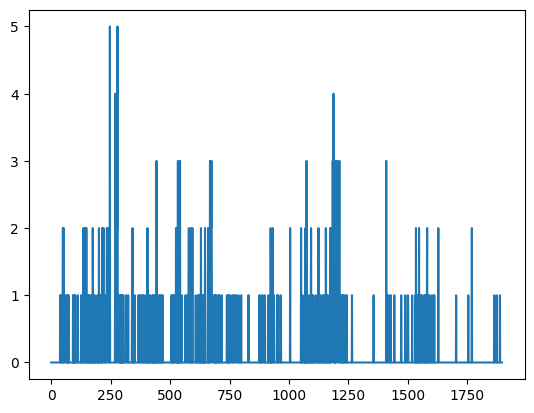

In [4]:
df[df['id'] == 0]['nbsinister'].plot()

In [18]:
df['is_duplicate'] = df.duplicated(subset=['id', 'date'])
duplicates = df[df['is_duplicate'] == True]
print(duplicates)

Empty DataFrame
Columns: [id, longitude, latitude, departement, date, weight, days_until_next_event, class_risk, nbsinister, risk, temp_mean, temp_min, temp_max, temp_std, temp_sum, dwpt_mean, dwpt_min, dwpt_max, dwpt_std, dwpt_sum, rhum_mean, rhum_min, rhum_max, rhum_std, rhum_sum, prcp_mean, prcp_min, prcp_max, prcp_std, prcp_sum, wdir_mean, wdir_min, wdir_max, wdir_std, wdir_sum, wspd_mean, wspd_min, wspd_max, wspd_std, wspd_sum, prec24h_mean, prec24h_min, prec24h_max, prec24h_std, prec24h_sum, dc_mean, dc_min, dc_max, dc_std, dc_sum, ffmc_mean, ffmc_min, ffmc_max, ffmc_std, ffmc_sum, dmc_mean, dmc_min, dmc_max, dmc_std, dmc_sum, nesterov_mean, nesterov_min, nesterov_max, nesterov_std, nesterov_sum, munger_mean, munger_min, munger_max, munger_std, munger_sum, kbdi_mean, kbdi_min, kbdi_max, kbdi_std, kbdi_sum, isi_mean, isi_min, isi_max, isi_std, isi_sum, angstroem_mean, angstroem_min, angstroem_max, angstroem_std, angstroem_sum, bui_mean, bui_min, bui_max, bui_std, bui_sum, fwi_mean

In [10]:
df = pd.read_csv( Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'train') / 'full_10_risk-watershed.csv')

In [19]:
df['risk'].mean(), df['risk'].var()

(0.509653462001127, 1.8427929869001984)

In [14]:
df[(df[:, 3] == 25) & (df[:, 4] == 256)]

array([[  8.        ,   6.79211341,  47.46743061,  25.        ,
        256.        ,   1.        ,   0.        ,   0.        ,
          0.        ],
       [  9.        ,   6.32481583,  46.97292114,  25.        ,
        256.        ,   1.        ,   0.        ,   0.        ,
          0.        ],
       [ 10.        ,   6.18904395,  46.77802907,  25.        ,
        256.        ,   1.        ,   0.        ,   0.        ,
          0.        ],
       [ 11.        ,   6.13245332,  47.11117275,  25.        ,
        256.        ,   1.        ,   0.        ,   0.        ,
          0.        ],
       [ 12.        ,   5.86495219,  47.17338721,  25.        ,
        256.        ,   1.        ,   0.        ,   0.        ,
          0.        ],
       [ 13.        ,   6.80794991,  47.31233884,  25.        ,
        256.        ,   1.        ,   0.        ,   0.        ,
          0.        ],
       [ 14.        ,   6.59075221,  47.14475712,  25.        ,
        256.        ,   1.    

<Axes: >

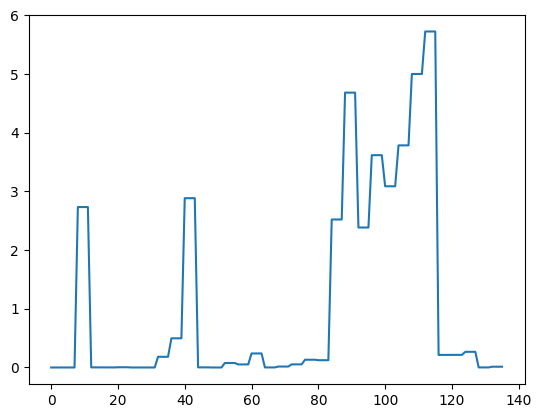

In [29]:
df[(df['id'] == 0) & (df['date'] >= allDates.index('2018-01-01')) & (df['date'] <= allDates.index('2018-04-01'))]['fwi_mean'].plot()

<Axes: >

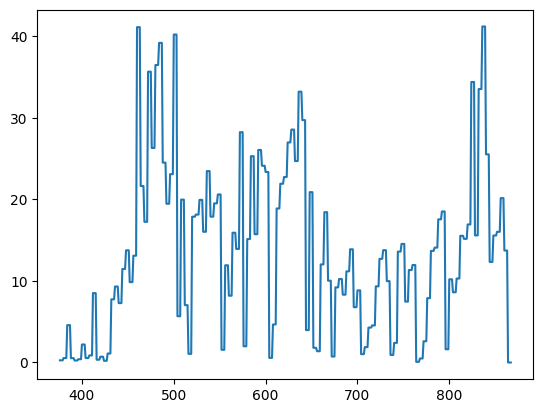

In [30]:
df[(df['id'] == 0) & (df['date'] >= allDates.index('2018-06-01')) & (df['date'] <= allDates.index('2018-10-01'))]['fwi_mean'].plot()

In [7]:
max_date = allDates.index('2023-01-01')

In [39]:
df['binary'] = (df['nbsinister'] > 0).astype(int)

In [63]:
from pygam import PoissonGAM, LogisticGAM, LinearGAM, GammaGAM, s
import numpy as np

df_train = df[df['date'] < max_date]
df_test = df[df['date'] >= max_date]

# Variables explicatives (features)
X = df_train[['fwi_mean', 'foret_encoder_mean', 'NDVI_mean']].values

# Variable cible (Fire Occurrence)
y = np.abs(df_train['risk'].values)

# Créer un modèle GAM de Poisson avec des splines sur FWI et FA
gam = LinearGAM(s(0) + s(1) + s(2))  # s(0) correspond à FWI, s(1) à FA

# Ajuster le modèle aux données
gam.fit(X, y)

# Afficher les résumés du modèle
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.3182
Link Function:                     IdentityLink Log Likelihood:                                -525379.659
Number of Samples:                       286923 AIC:                                          1050855.9543
                                                AICc:                                         1050855.9709
                                                GCV:                                                1.9191
                                                Scale:                                              1.9186
                                                Pseudo R-Squared:                                   0.1728
Feature Function                  Lam

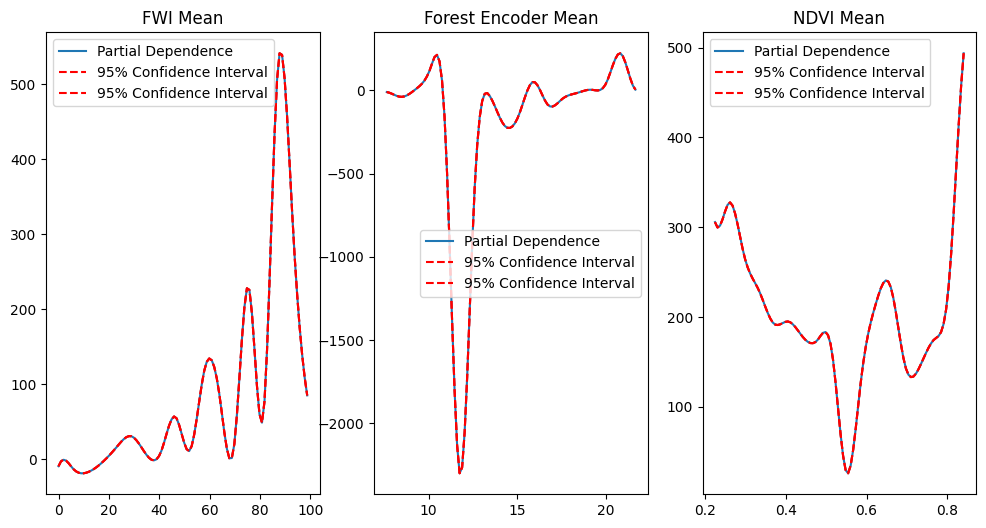

In [60]:
import matplotlib.pyplot as plt

# Visualisation des effets non linéaires de FWI et FA
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

titles = ['FWI Mean', 'Forest Encoder Mean', 'NDVI Mean']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    line1 = ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), label='Partial Dependence')
    line2 = ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--', label='95% Confidence Interval')
    ax.set_title(titles[i])
    ax.legend()  # Ajouter la légende pour chaque graphique

plt.show()

In [61]:
new_observation = df_test[['fwi_mean', 'foret_encoder_mean', 'NDVI_mean']]
new_observation[np.isnan(new_observation)] = 0
predicted_fire_occurrence = gam.predict(new_observation).astype(float)
df_test['predicted_fire_occurrence'] = predicted_fire_occurrence

/home/caron/Bureau/.conda/lib/python3.9/site-packages/pygam/links.py:197: RuntimeWarning: overflow encountered in exp
  return np.exp(lp)


<Axes: >

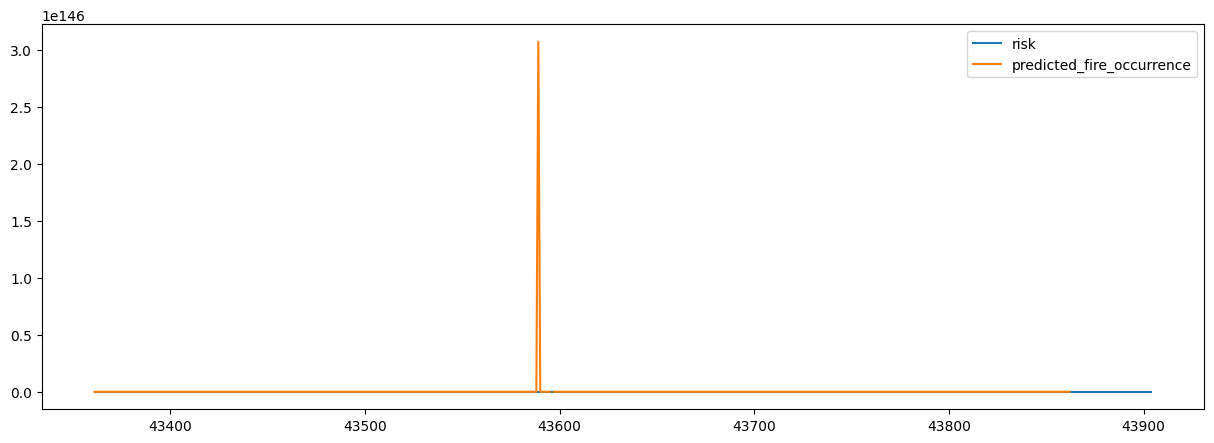

In [62]:
fig, ax = plt.subplots(figsize=(15,5))

df_test[df_test['id'] == 4][['risk', 'predicted_fire_occurrence']].plot(ax=ax)

<Axes: >

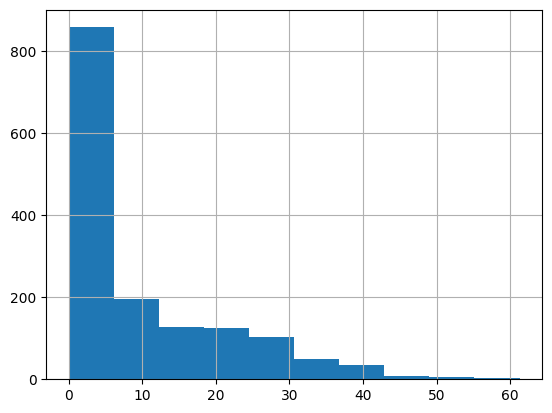

In [7]:
df.groupby('date')['fwi_max'].mean().reset_index()['fwi_max'].hist()

In [73]:
df['weight_normalize'].max()

16.239857950174223

In [52]:

df.reset_index(inplace=True)

In [68]:
df[(df['id'] == 27) & (df['date'] > allDates.index('2023-01-01'))]['risk'].reset_index(drop=True)[190:210]

190    2.619467
191    2.508251
192    3.636019
193    3.715018
194    3.826233
195    4.174917
196    6.445124
197    9.318453
198    7.826598
199    6.190946
200    4.572002
201    1.889202
202    0.794172
203    0.286131
204    0.000365
205    0.143326
206    0.254489
207    0.476399
208    1.000468
209    0.476555
Name: risk, dtype: float64

<Axes: >

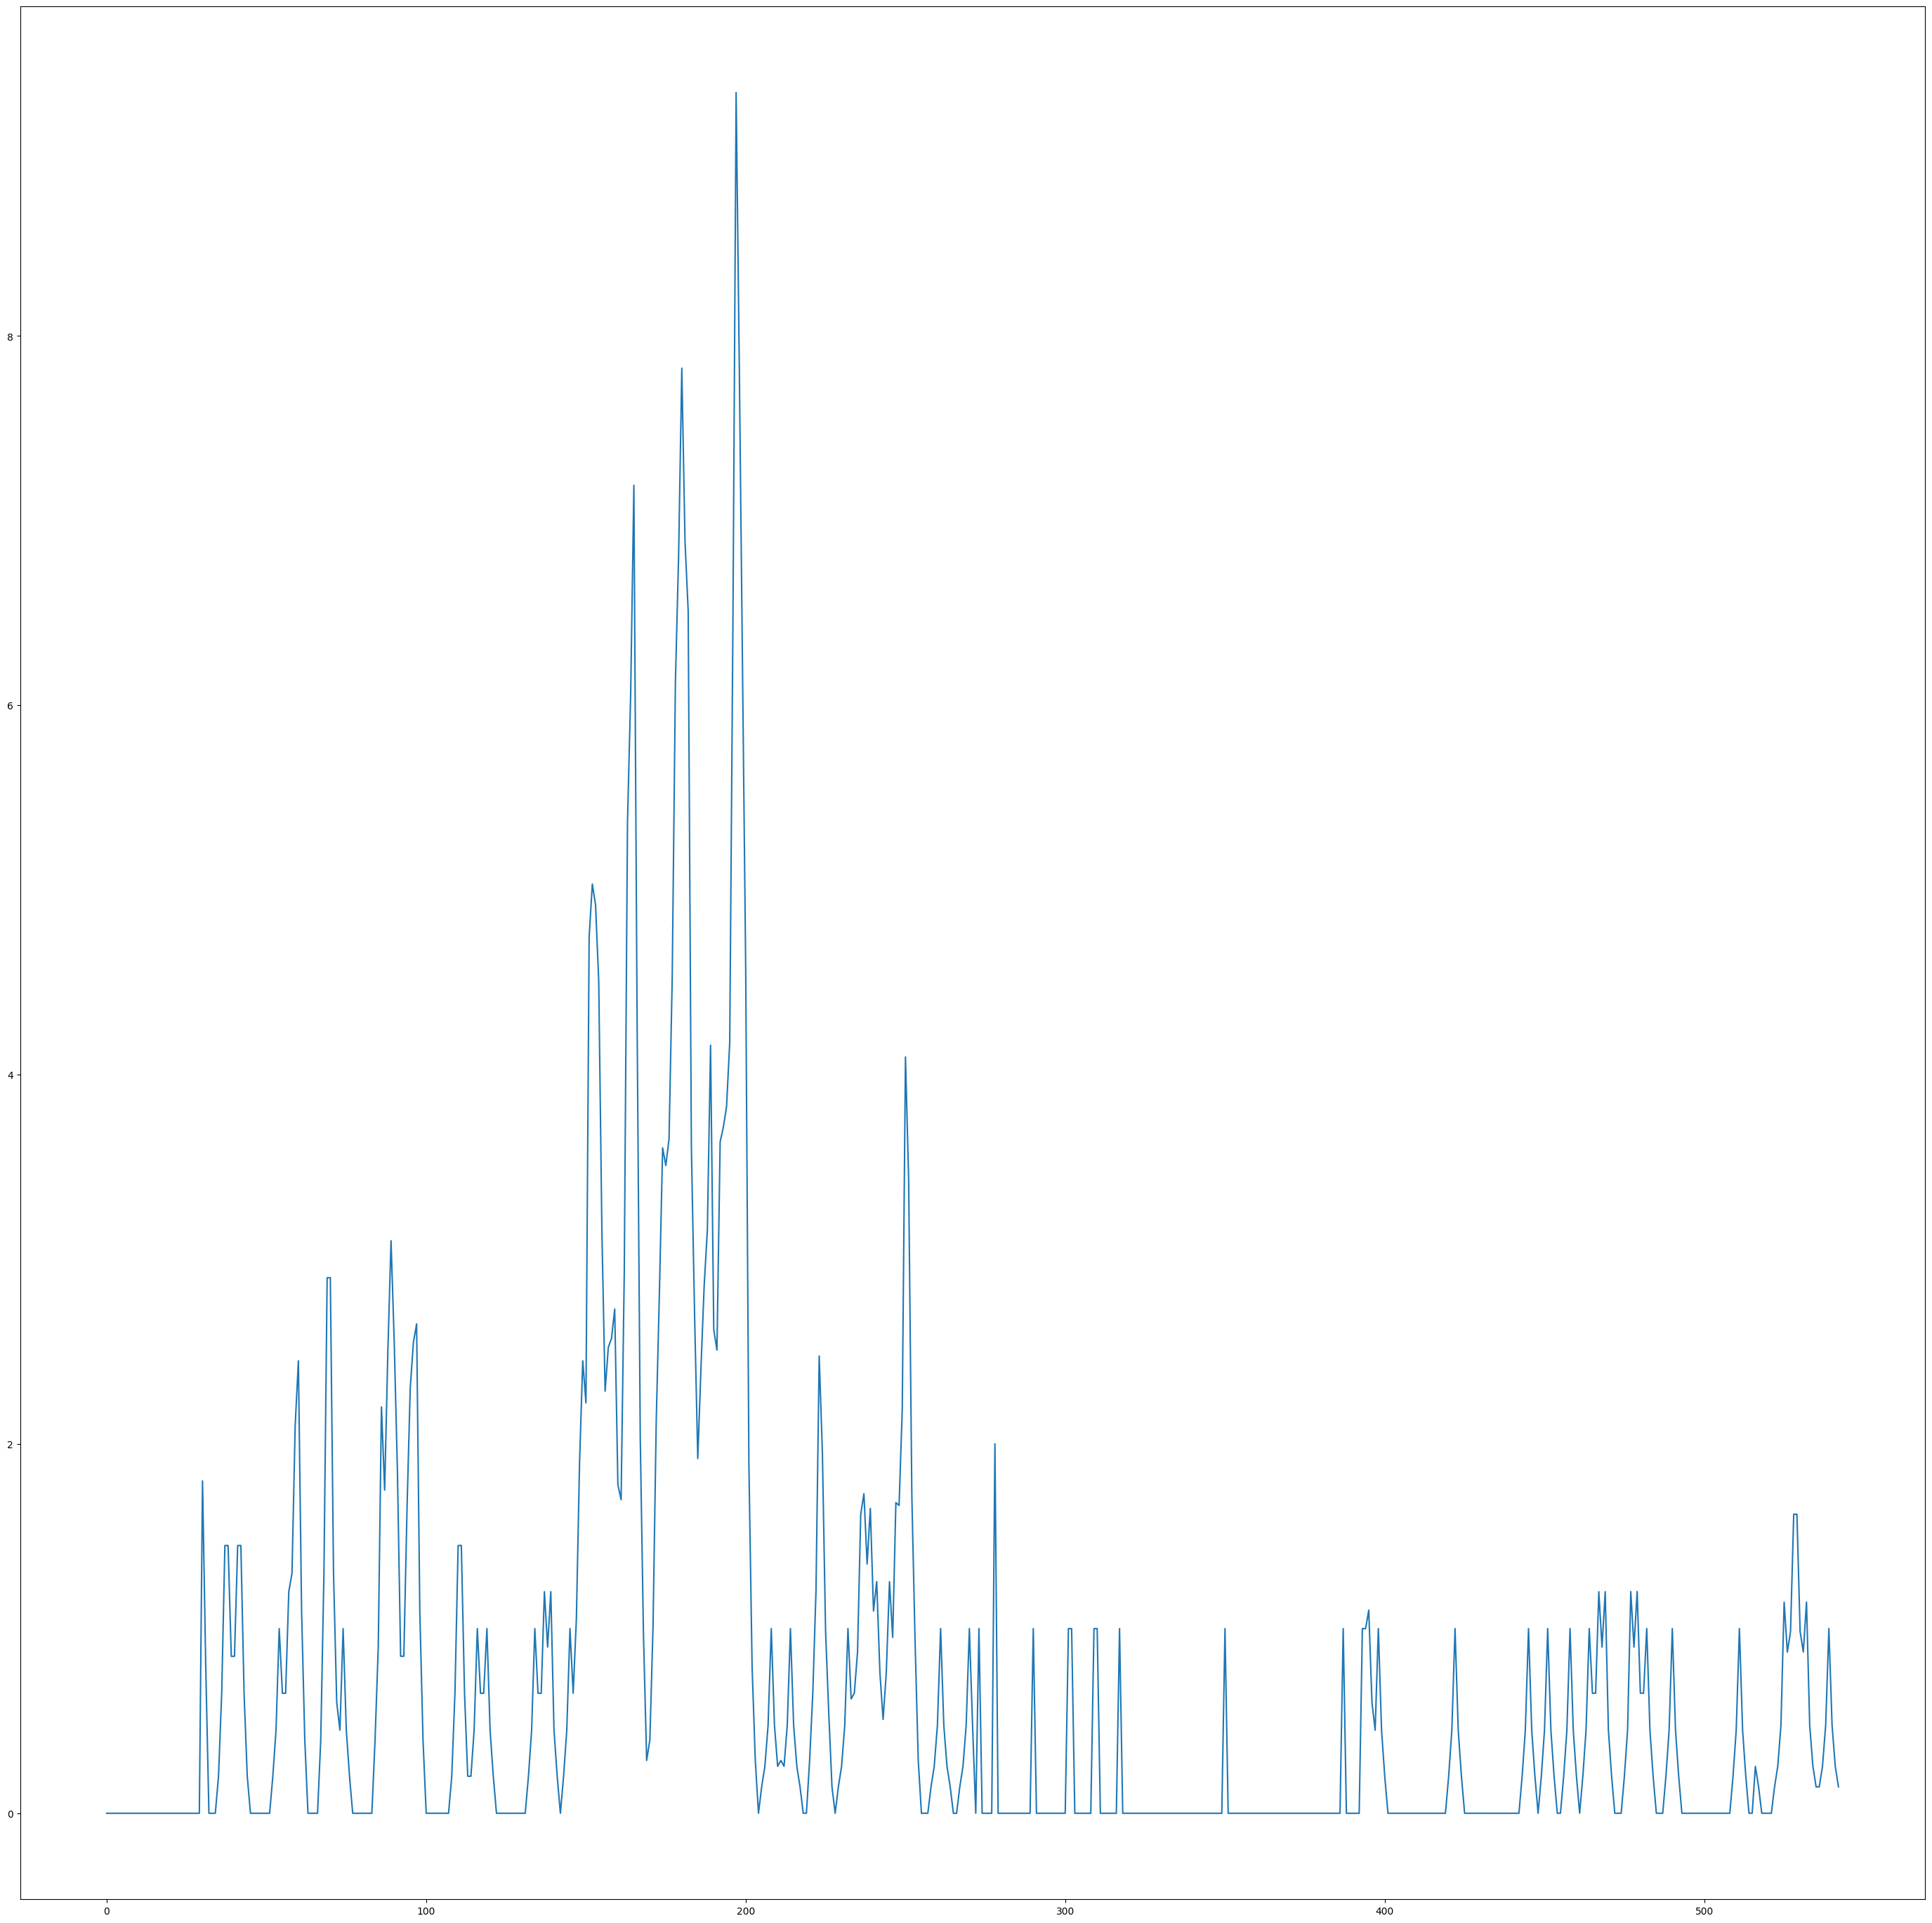

In [67]:
plt.figure(figsize=(35,35))
df[(df['id'] == 27) & (df['date'] > allDates.index('2023-01-01'))]['risk'].reset_index(drop=True).plot()

In [15]:
df['id_encoder_max'].unique()

array([ 22.422,  16.235,  19.455,  14.405,  22.384,   3.947,   5.314,
         6.596,   5.122,   5.295,   7.422,   4.457,  52.183,  50.008,
         8.221,   5.67 ,   5.655,   7.595,   5.68 ,   6.754,   6.633,
         4.321,  16.466,   3.832,   4.402,  13.084,  14.133,  84.313,
       102.792,  15.479,  11.167,  18.28 ,  23.082])

In [6]:
df['weight_proportion_on_zero_sinister'].unique()

array([ 1.        ,  0.        , 10.85107692])

In [11]:
df['argile_encoder_mean'].unique()

array([20.789, 21.84 , 21.591, 21.753, 21.776, 21.341, 20.703, 20.655,
       21.838, 21.583, 21.785, 21.242, 21.561, 21.605, 19.279, 20.431,
       19.764, 21.674, 21.188, 20.754, 21.595, 21.882, 16.042, 15.356,
       13.958, 14.768, 19.473, 19.855, 20.864, 20.069, 18.213, 19.87 ,
       18.401])

In [9]:
allDates.index('2023-11-01')

2333

<Axes: >

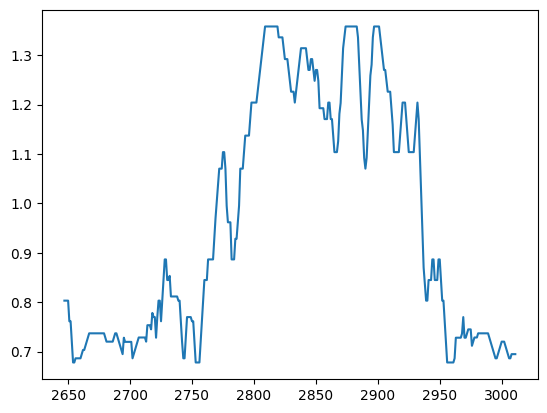

In [18]:
df[(df['weight'] > 0) & (df['id'] == 0) & (df['date'] >= allDates.index('2023-01-01')) & (df['date'] <= allDates.index('2023-12-31'))]['temp_mean_frequencyratio_mean_7'].plot()
#df[(df['weight'] > 0) & (df['id'] == 0) & (df['date'] >= allDates.index('2023-01-01')) & (df['date'] <= allDates.index('2023-12-31'))]['temp_min'].plot()
#df[(df['weight'] > 0) & (df['id'] == 0) & (df['date'] >= allDates.index('2023-01-01')) & (df['date'] <= allDates.index('2023-12-31'))]['temp_mean'].plot()

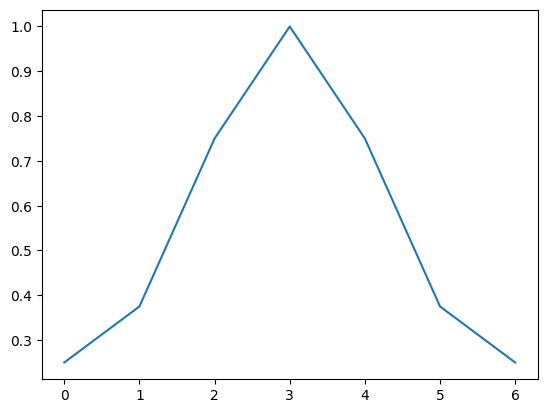

In [7]:
import numpy as np
import matplotlib.pyplot as plt
kernel_size = 7

kernel = np.abs(np.linspace(-kernel_size // 2 * 1, kernel_size // 2 * 1 + 1, kernel_size))
kernel[kernel.shape[0] // 2] = 1
plt.plot(1 / kernel)

In [19]:
for col in df.columns:
    print(col, df[col].dtype)

id float64
longitude float64
latitude float64
departement float64
date float64
weight float64
days_until_next_event int64
class_risk float64
nbsinister float64
risk float64
temp_mean float64
temp_min float64
temp_max float64
temp_std float64
temp_sum float64
dwpt_mean float64
dwpt_min float64
dwpt_max float64
dwpt_std float64
dwpt_sum float64
rhum_mean float64
rhum_min float64
rhum_max float64
rhum_std float64
rhum_sum float64
prcp_mean float64
prcp_min float64
prcp_max float64
prcp_std float64
prcp_sum float64
wdir_mean float64
wdir_min float64
wdir_max float64
wdir_std float64
wdir_sum float64
wspd_mean float64
wspd_min float64
wspd_max float64
wspd_std float64
wspd_sum float64
prec24h_mean float64
prec24h_min float64
prec24h_max float64
prec24h_std float64
prec24h_sum float64
dc_mean float64
dc_min float64
dc_max float64
dc_std float64
dc_sum float64
ffmc_mean float64
ffmc_min float64
ffmc_max float64
ffmc_std float64
ffmc_sum float64
dmc_mean float64
dmc_min float64
dmc_max float64

<Axes: >

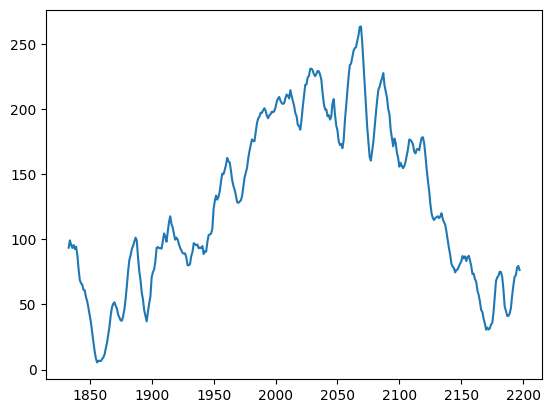

In [32]:
df[(df['weight'] > 0) & (df['id'] == 0) & (df['date'] >= allDates.index('2023-01-01')) & (df['date'] <= allDates.index('2023-12-31'))]['temp_mean_7'].plot()

In [9]:
df.dropna().shape

(49603, 1821)

In [8]:
allDates.index('2023-08-28')

2268

<Axes: >

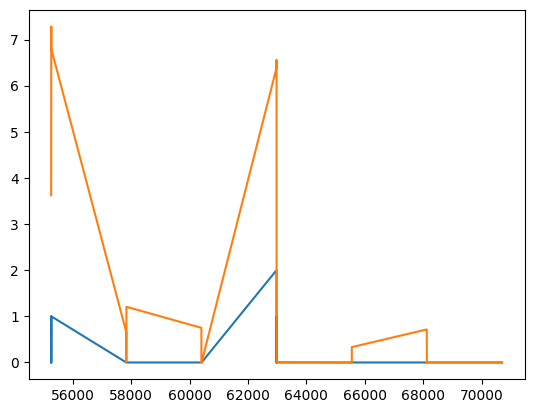

In [26]:
df[(df['departement'] == 78) & (df['date'] > allDates.index('2023-08-28') - 7) & (df['date'] <= allDates.index('2023-08-28'))]['AutoRegressionBin_B-1'].plot()
df[(df['departement'] == 78) & (df['date'] > allDates.index('2023-08-28') - 7) & (df['date'] <= allDates.index('2023-08-28'))]['risk'].plot()

In [25]:
df[['AutoRegressionBin_B-1', 'NO2', 'NO2_max_1', 'NO2_max_2', 'NO2_max_3',
 'NO2_max_4', 'NO2_mean_1', 'NO2_mean_2', 'NO2_mean_3', 'NO2_mean_4',
 'NO2_min_1', 'NO2_min_2', 'NO2_min_3', 'NO2_min_4', 'NO2_std_1', 'NO2_std_2',
 'NO2_std_3', 'NO2_std_4', 'O3', 'O3_max_1', 'O3_mean_1', 'O3_min_1', 'O3_std_1',
 'PM10', 'PM10_max_1', 'PM10_max_2', 'PM10_max_3', 'PM10_max_4', 'PM10_max_5',
 'PM10_max_6', 'PM10_mean_1', 'PM10_mean_2', 'PM10_mean_3', 'PM10_mean_4',
 'PM10_mean_5', 'PM10_mean_6', 'PM10_min_1', 'PM10_min_2', 'PM10_min_3',
 'PM10_min_4', 'PM10_min_5', 'PM10_min_6', 'PM10_std_1', 'PM10_std_2',
 'PM10_std_3', 'PM10_std_4', 'PM10_std_5', 'PM10_std_6', 'PM25', 'PM25_max_1',
 'PM25_max_2', 'PM25_max_3', 'PM25_max_4', 'PM25_max_5', 'PM25_max_6',
 'PM25_max_7', 'PM25_mean_1', 'PM25_mean_2', 'PM25_mean_3', 'PM25_mean_4',
 'PM25_mean_5', 'PM25_mean_6', 'PM25_mean_7', 'PM25_min_1', 'PM25_min_2',
 'PM25_min_3', 'PM25_min_4', 'PM25_min_5', 'PM25_min_6', 'PM25_min_7',
 'PM25_std_1', 'PM25_std_2', 'PM25_std_3', 'PM25_std_4', 'PM25_std_5',
 'PM25_std_6', 'PM25_std_7']
].dropna()

,AutoRegressionBin_B-1,NO2,NO2_max_1,NO2_max_2,NO2_max_3,NO2_max_4,NO2_mean_1,NO2_mean_2,NO2_mean_3,NO2_mean_4,...,PM25_min_5,PM25_min_6,PM25_min_7,PM25_std_1,PM25_std_2,PM25_std_3,PM25_std_4,PM25_std_5,PM25_std_6,PM25_std_7
119,1.0,9.800000,9.800000,9.800000,9.800000,12.700000,6.550000,6.600000,7.400000,8.460000,...,10.8,10.8,10.8,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
120,0.0,2.300000,9.800000,9.800000,9.800000,9.800000,6.050000,5.133333,5.525000,6.380000,...,10.8,10.8,10.8,1.05,1.050000,1.050000,1.050000,1.050000,1.050000,1.050000
121,0.0,6.700000,6.700000,9.800000,9.800000,9.800000,4.500000,6.266667,5.525000,5.760000,...,10.8,10.8,10.8,1.50,2.092845,2.092845,2.092845,2.092845,2.092845,2.092845
122,0.0,3.600000,6.700000,6.700000,9.800000,9.800000,5.150000,4.200000,5.600000,5.140000,...,5.7,5.7,5.7,5.10,4.280187,3.719123,3.719123,3.719123,3.719123,3.719123
123,0.0,8.000000,8.000000,8.000000,8.000000,9.800000,5.800000,6.100000,5.150000,6.080000,...,5.7,5.7,5.7,0.50,4.590812,4.249706,3.806311,3.806311,3.806311,3.806311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71004,0.0,1.369231,1.369231,3.715385,7.338462,7.550000,1.294231,2.101282,3.410577,4.238462,...,3.1,1.6,1.6,0.05,4.172130,3.625862,3.248630,3.273632,3.431725,3.335791
71005,0.0,6.846154,6.846154,6.846154,6.846154,7.338462,4.107692,3.144872,3.287500,4.097692,...,3.9,3.1,1.6,0.75,0.731817,3.663673,3.279878,3.006105,3.040677,3.210116
71006,0.0,7.546154,7.546154,7.546154,7.546154,7.546154,7.196154,5.253846,4.245192,4.139231,...,3.9,3.9,3.1,2.25,2.549510,2.478407,3.555615,3.268877,3.026751,3.123074
71008,0.0,3.988462,3.988462,7.546154,7.546154,7.546154,3.790385,5.042308,5.493269,4.668462,...,3.9,3.9,3.9,4.20,4.327689,5.172705,5.552513,5.576737,5.322919,5.106613


In [26]:
features[:, 0]

array(['pastinfluence_max', 'pastinfluence_mean', 'pastinfluence_std',
       'bui_max', 'dmc_max', 'AutoRegressionBin_B-1', 'bui_mean',
       'PasDeforet_max', 'Châtaignier_std', 'dayofyear',
       'Chênes décidus_max', 'NR_max', 'Mixte_max', 'elevation_min',
       'foret_encoder_std', 'foret_encoder_max', 'Peuplier_max',
       'elevation_mean', 'elevation_std', 'Peuplier_mean', 'bui_mean_1',
       'bui_min', 'Hêtre_mean', 'dc_mean', 'nesterov_std',
       'secondary_max', 'kbdi_max', 'munger_max', 'Mixte_mean',
       'ffmc_std', 'Conifères_max', 'dc_max', 'Conifères_mean',
       'days_since_rain_max', 'munger_min', 'Feuillus_max', 'rhum_max',
       'Robinier_mean', 'dc_std', 'dmc_std', 'PasDeRoute_min',
       'rhum_mean', 'tertiary_max', 'dmc_mean', 'NC_max', 'elevation_max',
       'Chênes décidus_mean', 'motorway_max', 'PasDeforet_min', 'NC_mean',
       'PasDeforet_std', 'Peuplier_std', 'Pin laricio, pin noir_mean',
       'Robinier_max', 'population_mean', 'dmc_min', 'ne

<Axes: >

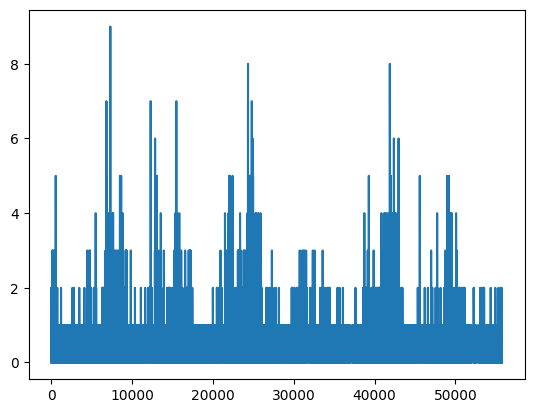

In [19]:
df.sort_values('date').reset_index()['AutoRegressionBin_B-1'].plot()

In [29]:
df = df[list(features[:, 0]) + ids_columns]

In [23]:
df.shape, df.dropna().shape

((55762, 1821), (38173, 1821))

In [45]:
df.id.unique(), df.dropna().id.unique(),

(array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8., 11., 13., 15., 17., 18.,
        19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.]),
 array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8., 11., 13., 15., 17., 18.,
        19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.]))

In [47]:
df[df['departement'] == 25].id.unique()

array([11., 13., 15.])

In [30]:
np.unique(df.columns[df.isna().any()].tolist())

array(['AutoRegressionBin_B-1'], dtype='<U21')

In [41]:
df[df['AutoRegressionBin_B-1'].isna()].date.unique()

array([0.])

<Axes: >

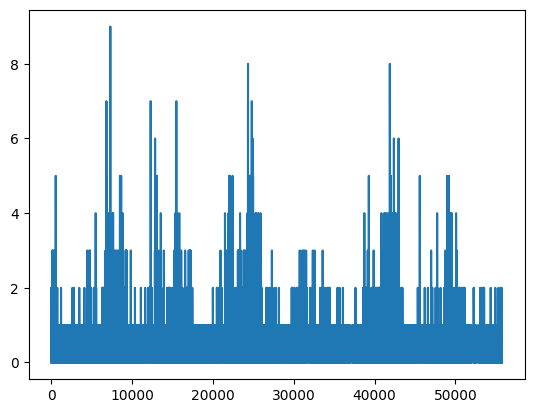

In [32]:
df.sort_values('date').reset_index()['AutoRegressionBin_B-1'].plot()

In [ ]:
plt.plot(df.dailySeverityRating_max)

NameError: name 'plt' is not defined

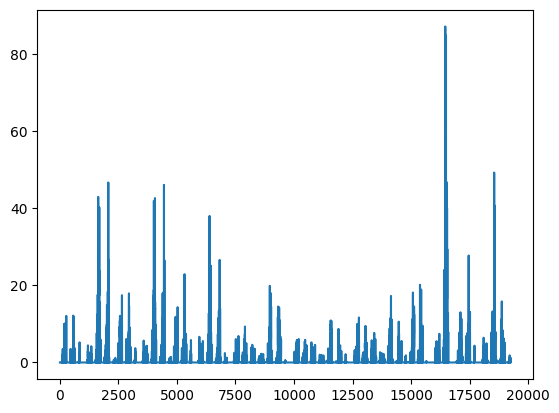

In [7]:
plt.plot(df['dailySeverityRating_min'])

In [25]:
df['isweekend_sum_7'].unique()

array([ 3.53808859,  7.07617718, 10.61426578, 14.15235437, 17.69044296,
       21.31854351, 24.94664405, 28.48473264, 28.48473264, 28.57474459])

<Axes: >

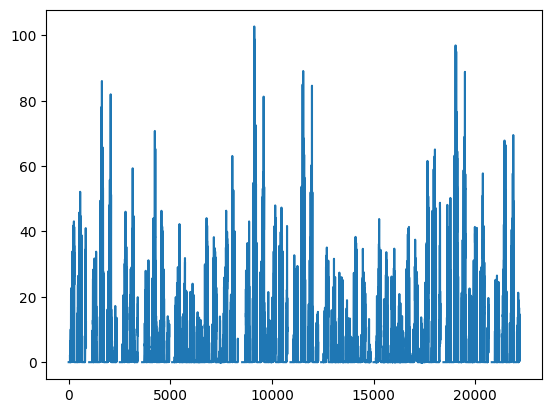

In [21]:
df['fwi_mean'].plot()

In [ ]:
pred1 = read_object('xgboost_nbsinister_full_0_10_100_10_z-score_Catboost_departement-78-yvelines_pred.pkl',
                    Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'test/departement-78-yvelines/full_0_10_100/xgboost_nbsinister'))
pred2 = read_object('xgboost_risk_full_0_10_100_10_z-score_Catboost_departement-78-yvelines_pred.pkl',
                    Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'test/departement-78-yvelines/full_0_10_100/xgboost_risk'))

In [46]:
pred1.shape

(3591, 13)

In [1]:
graph._plot(graph.nodes[graph.nodes[:, 3] == 78])

NameError: name 'graph' is not defined

In [39]:
np.argwhere(X == np.nanmax(X))

array([[2996,   60]])

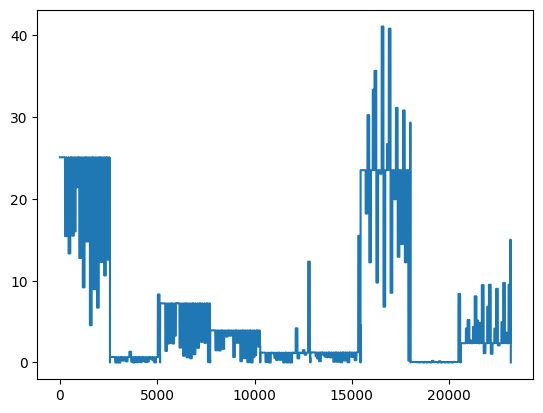

In [43]:
plt.plot(X[:, 360])

In [30]:
X[:, 0]

array([0., 0., 0., ..., 8., 8., 8.])

In [51]:
x50 = X[X[:, 0] == 8]
y50 = Y[Y[:, 0] == 17]
x47 = X[X[:, 0] == 0]

In [7]:
x50[:, 1], y50[:, 1]

(array([5.62185654, 5.62185654, 5.62185654, ..., 5.62185654, 5.62185654,
        5.62185654]),
 array([5.62185654, 5.62185654, 5.62185654, ..., 5.62185654, 5.62185654,
        5.62185654]))

In [36]:
features_name.index('Calendar') + (calendar_variables.index('dayofweek'))

368

In [15]:
X[:, features_name.index('dynamicWorld') + (3 * 4) + 1].min()

0.0

In [10]:
x50

array([], shape=(0, 403), dtype=float64)

In [53]:
np.unique(x50[:, 366])

array([ 0.45487033,  0.51257905,  0.74163637,  1.87137873,  1.93781528,
        2.04838418,  2.79741432,  4.41099934,  4.61160282,  5.03517491,
        6.90820623, 10.18624031])

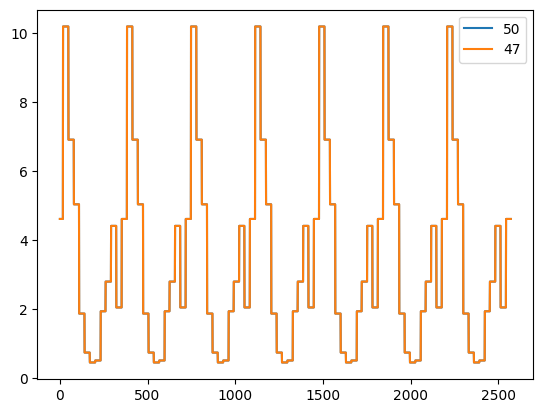

In [52]:
plt.plot(x50[:, 366], label='50')
plt.plot(x47[:, 366], label='47')
plt.legend()

In [57]:
np.unique(X[:, features_name.index('Geo')])

array([2.70325304, 3.49902871, 3.56373677, 4.48892857])

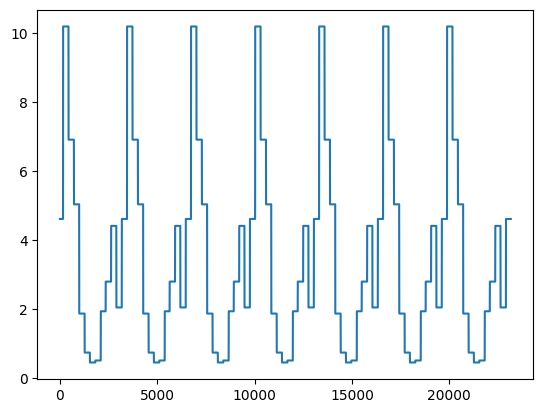

In [55]:
X2 = X[X[:, 3] == 78]
ind = np.lexsort([X2[:, 4]])
X2 = X2[ind]
plt.plot(X2[:, features_name.index('Calendar') + calendar_variables.index('month')])

In [52]:
allDates[1493]

'2021-07-14'

In [47]:
maxi = X2[:, features_name.index('Calendar') + calendar_variables.index('dayofyear')].max()
X2[X2[:, features_name.index('Calendar') + calendar_variables.index('dayofyear')] == maxi][:, 4]

array([  32.,  397.,  762., 1128., 1493., 1858., 2223.])

In [36]:
X[X[:, 3] == 1, 288].max()

17.550297

In [32]:
ain = X[X[:, 3] == 1]
ain[ain[:, 272] == np.max(ain[:, 272])][:, 0]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2.])

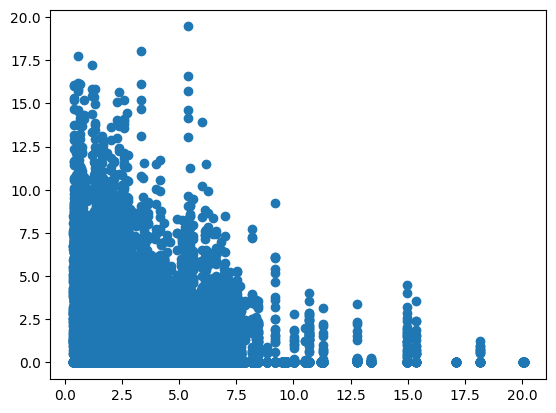

In [41]:
plt.scatter(X[X[:, 3] == 1, 266], Y[X[:, 3] == 1, -1])

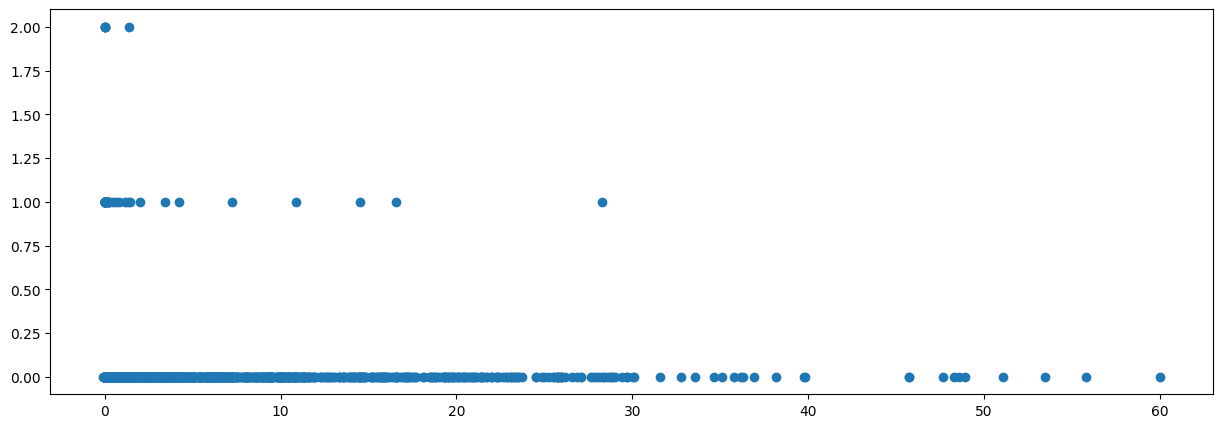

In [41]:
plt.figure(figsize=(15,5))
plt.scatter(x50[:, features_name.index('prec24h')], y50[:, -2])

In [51]:
firepointcsv = pd.read_csv('/home/caron/Bureau/csv/departement-01-ain/firepoint/NATURELSfire.csv')

In [55]:
firepointcsv[firepointcsv['date'] == '2018-04-12']

,id_intervention,raison_sortie,date_debut,date_fin,FL_CCR_CCF,nb_eng_CC,label,year,geometry,latitude,longitude,IN,date,type,coef,h3
66,18BB016480,NATURELS,2018-04-12 16:52:38,2018-04-12 17:15:01,1.0,1.0,1.0,2018,POINT (5.693479892334558 45.71028415571681),45.710284,5.693480,True,2018-04-12,NATURELS,1.0,871f9171effffff
67,18BB016500,NATURELS,2018-04-12 19:11:22,2018-04-12 21:59:45,1.0,3.0,1.0,2018,POINT (5.809188142285021 46.08798626074307),46.087986,5.809188,True,2018-04-12,NATURELS,1.0,871f91075ffffff
68,18BB016516,NATURELS,2018-04-12 20:39:51,2018-04-12 21:20:52,1.0,1.0,1.0,2018,POINT (5.655320778801857 46.257765120417965),46.257765,5.655321,True,2018-04-12,NATURELS,1.0,871f918ceffffff


In [59]:
firepointcsv['id'] = graph._predict_node_with_position(list(zip(firepointcsv.longitude, firepointcsv.latitude)))
firepointcsv[firepointcsv['date'] == '2018-04-12'].id

66    50
67    56
68    26
Name: id, dtype: int32

In [56]:
fire = y50[y50[:, -2] > 0]
dates = [allDates[int(f)] for f in np.unique(fire[:, 4])]

for d in dates:
    if d not in firepointcsv.date.unique():
        print(d)

In [6]:
features_name

{'temp': 6,
 'dwpt': 10,
 'rhum': 14,
 'prcp': 18,
 'wdir': 22,
 'wspd': 26,
 'prec24h': 30,
 'dc': 34,
 'ffmc': 38,
 'dmc': 42,
 'nesterov': 46,
 'munger': 50,
 'kbdi': 54,
 'isi': 58,
 'angstroem': 62,
 'bui': 66,
 'fwi': 70,
 'dailySeverityRating': 74,
 'temp16': 78,
 'dwpt16': 82,
 'rhum16': 86,
 'prcp16': 90,
 'wdir16': 94,
 'wspd16': 98,
 'prec24h16': 102,
 'days_since_rain': 106,
 'sum_consecutive_rainfall': 110,
 'sum_last_7_days': 114,
 'elevation': 118,
 'population': 122,
 'sentinel': 126,
 'landcover': 146,
 'vigicrues': 154,
 'foret': 158,
 'highway': 234,
 'dynamicWorld': 258,
 'Calendar': 294,
 'Historical': 309,
 'Geo': 313,
 'air': 314,
 'nappes': 318,
 'AutoRegressionReg': 326,
 'AutoRegressionBin': 327}

In [120]:
X[:, features_name.index('vigicrues'): features_name.index('vigicrues') + 4] = -1

In [140]:
np.unique(X[:, :127], axis=0).shape, np.unique(Y, axis=0).shape

((8164, 127), (8162, 9))

In [100]:
X.shape

(10211, 328)

In [40]:
iuds = np.unique(Y[:, 0])
for iud in iuds:
    zerosiud = Y[Y[:, 0] == iud]
    if zerosiud.shape != np.unique(zerosiud, axis=0).shape:
        print(iud, zerosiud.shape, np.unique(zerosiud, axis=0).shape)

0.0 (332, 9) (243, 9)
2.0 (399, 9) (318, 9)
3.0 (224, 9) (173, 9)
5.0 (401, 9) (319, 9)
6.0 (327, 9) (258, 9)
8.0 (397, 9) (339, 9)
9.0 (417, 9) (326, 9)
10.0 (155, 9) (145, 9)
11.0 (406, 9) (331, 9)
12.0 (163, 9) (138, 9)
13.0 (376, 9) (317, 9)
15.0 (256, 9) (190, 9)
16.0 (362, 9) (266, 9)
17.0 (411, 9) (328, 9)
18.0 (406, 9) (333, 9)
20.0 (443, 9) (355, 9)
23.0 (350, 9) (253, 9)
24.0 (280, 9) (216, 9)
25.0 (401, 9) (314, 9)
26.0 (317, 9) (240, 9)
28.0 (400, 9) (327, 9)
29.0 (384, 9) (311, 9)
30.0 (455, 9) (371, 9)
31.0 (385, 9) (315, 9)
32.0 (317, 9) (238, 9)
33.0 (429, 9) (335, 9)
34.0 (211, 9) (172, 9)
36.0 (412, 9) (339, 9)
38.0 (395, 9) (327, 9)


In [39]:
iuds = np.unique(X[:, 0])
for iud in iuds:
    zerosiud = X[X[:, 0] == iud]
    if zerosiud.shape != np.unique(zerosiud, axis=0).shape:
        print(iud, zerosiud.shape, np.unique(zerosiud, axis=0).shape)

0.0 (332, 328) (243, 328)
2.0 (399, 328) (343, 328)
3.0 (224, 328) (173, 328)
5.0 (401, 328) (340, 328)
6.0 (327, 328) (258, 328)
8.0 (397, 328) (349, 328)
9.0 (417, 328) (326, 328)
10.0 (155, 328) (145, 328)
11.0 (406, 328) (346, 328)
12.0 (163, 328) (138, 328)
13.0 (376, 328) (329, 328)
15.0 (256, 328) (190, 328)
16.0 (362, 328) (266, 328)
17.0 (411, 328) (328, 328)
18.0 (406, 328) (350, 328)
20.0 (443, 328) (384, 328)
23.0 (350, 328) (253, 328)
24.0 (280, 328) (216, 328)
25.0 (401, 328) (340, 328)
26.0 (317, 328) (240, 328)
28.0 (400, 328) (327, 328)
29.0 (384, 328) (328, 328)
30.0 (455, 328) (393, 328)
31.0 (385, 328) (337, 328)
32.0 (317, 328) (238, 328)
33.0 (429, 328) (363, 328)
34.0 (211, 328) (172, 328)
36.0 (412, 328) (353, 328)
38.0 (395, 328) (342, 328)


In [67]:
twoID = np.argwhere(X[:, 0] == 2)[:, 0]

X2 = X[twoID]
Y2 = Y[twoID]

X2.shape, Y2.shape 

((2371, 328), (2371, 9))

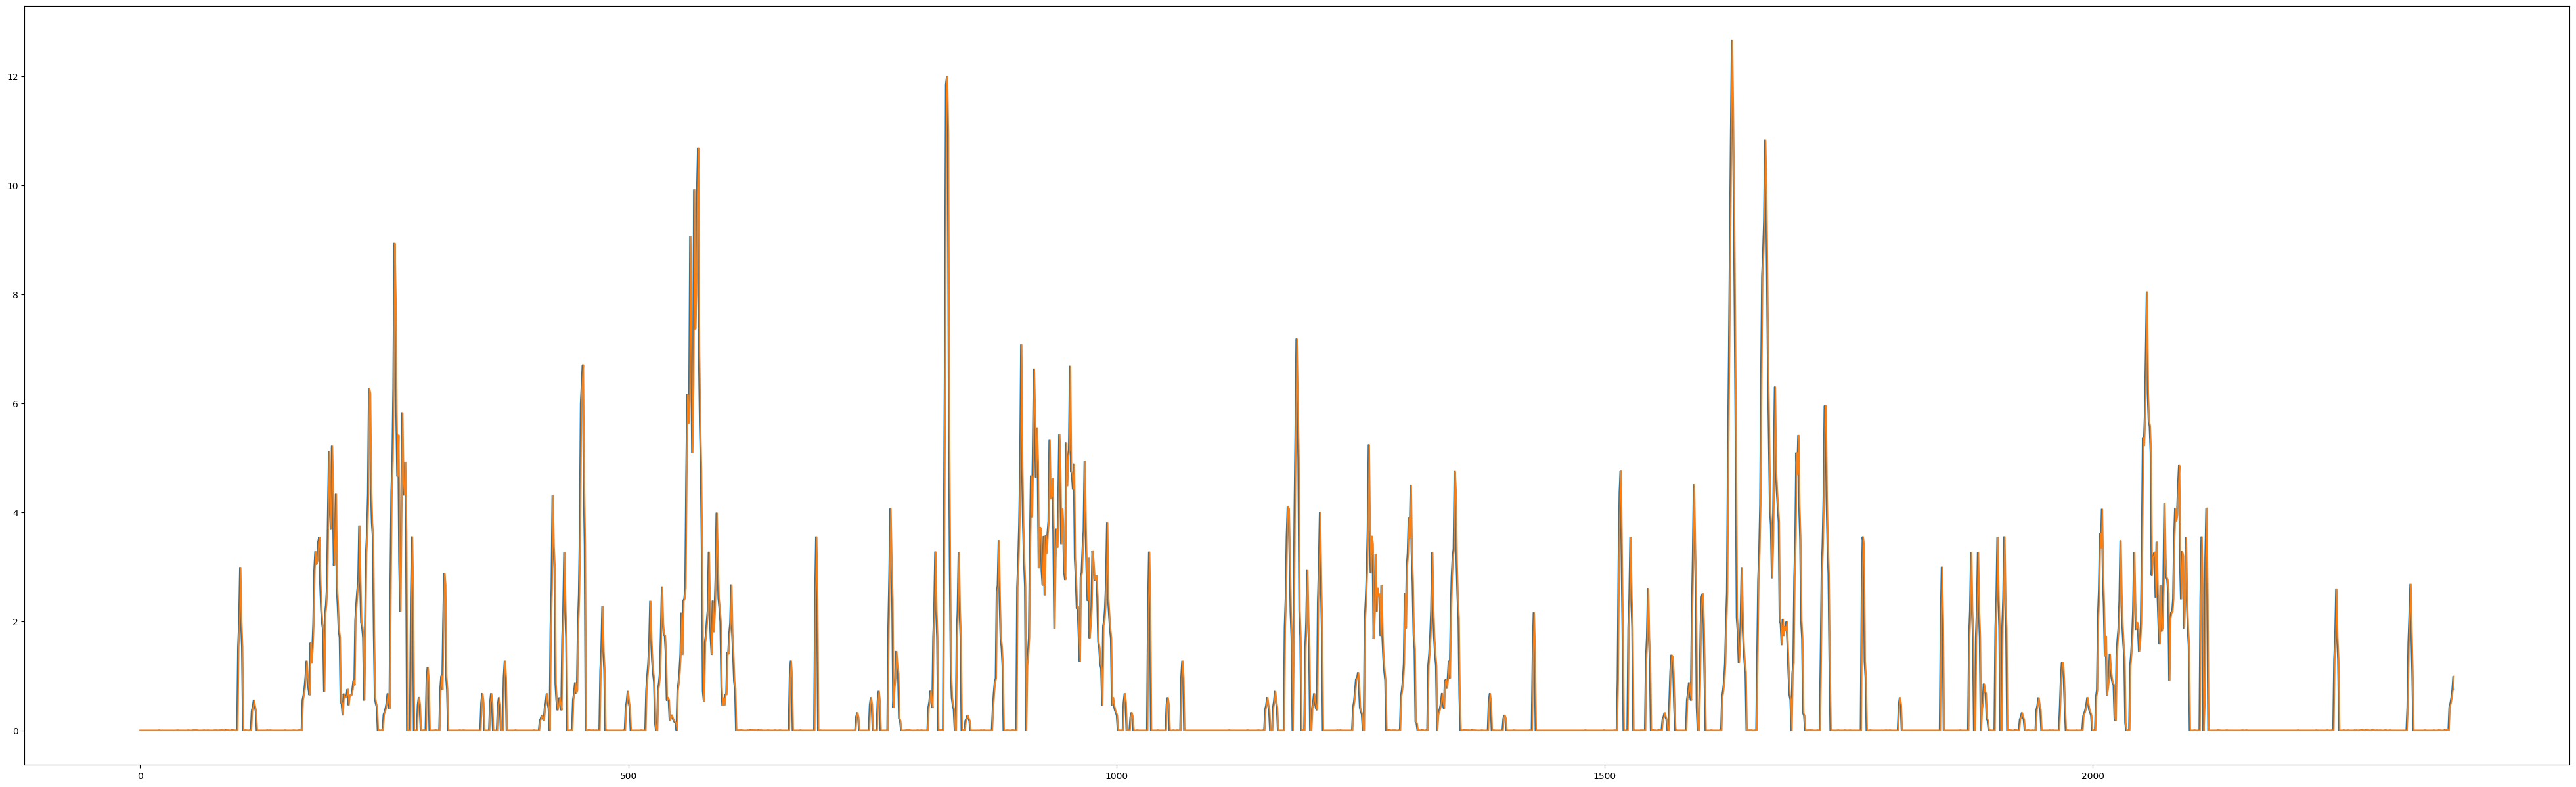

In [90]:
plt.figure(figsize=(50,15))
#plt.plot(np.unique(Y2, axis=0)[:, -2])
plt.plot(Y2[:, -1])
plt.plot(X2[:, -2])

In [77]:
np.unique(X2[:, -1] == Y2[:, -2])

array([False,  True])

In [62]:
np.sum(Y[:, -2]), np.sum([np.unique(Y2, axis=0)[:, -2]]), np.sum(X[:, -1])

(819.0, 21.0, 797.0)

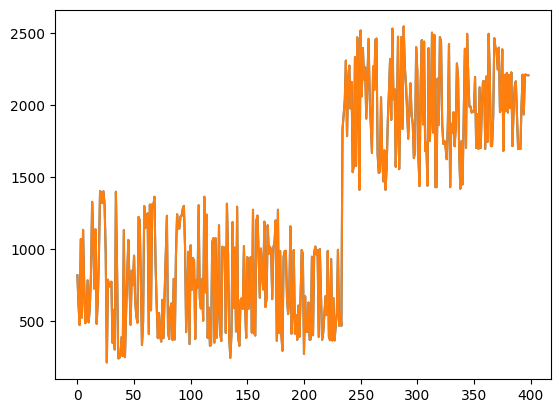

In [48]:
plt.plot(X2[:, 4])
plt.plot(Y2[:, 4])

In [17]:
features_name

{'temp': 6,
 'dwpt': 10,
 'rhum': 14,
 'prcp': 18,
 'wdir': 22,
 'wspd': 26,
 'prec24h': 30,
 'dc': 34,
 'ffmc': 38,
 'dmc': 42,
 'nesterov': 46,
 'munger': 50,
 'kbdi': 54,
 'isi': 58,
 'angstroem': 62,
 'bui': 66,
 'fwi': 70,
 'dailySeverityRating': 74,
 'temp16': 78,
 'dwpt16': 82,
 'rhum16': 86,
 'prcp16': 90,
 'wdir16': 94,
 'wspd16': 98,
 'prec24h16': 102,
 'days_since_rain': 106,
 'sum_consecutive_rainfall': 110,
 'sum_last_7_days': 114,
 'elevation': 118,
 'population': 122,
 'sentinel': 126,
 'landcover': 146,
 'vigicrues': 154,
 'foret': 158,
 'highway': 234,
 'dynamicWorld': 258,
 'Calendar': 294,
 'Historical': 309,
 'Geo': 313,
 'air': 314,
 'nappes': 318,
 'AutoRegressionReg': 326,
 'AutoRegressionBin': 327}

In [ ]:
np.unique()

In [30]:
np.round(np.unique(X[:, features_name.index('highway') + 0]))

array([92., 92., 93., 93., 93., 94., 95., 95., 95., 95., 95., 95., 95.,
       96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96.,
       96., 96., 96., 97., 97., 97., 97., 97., 97., 97., 97., 97., 97.,
       97., 97., 97., 97., 97., 97., 97., 97., 97., 97., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98.])

In [1]:
plt.figure(figsize=(15,5))
plt.plot(Y[:, -3])
#plt.plot(Y[:, -1])
print(np.sum(Y[:, -2]))
print(np.sum(Y[Y[:, 3] == 78][:, -3]))

NameError: name 'plt' is not defined

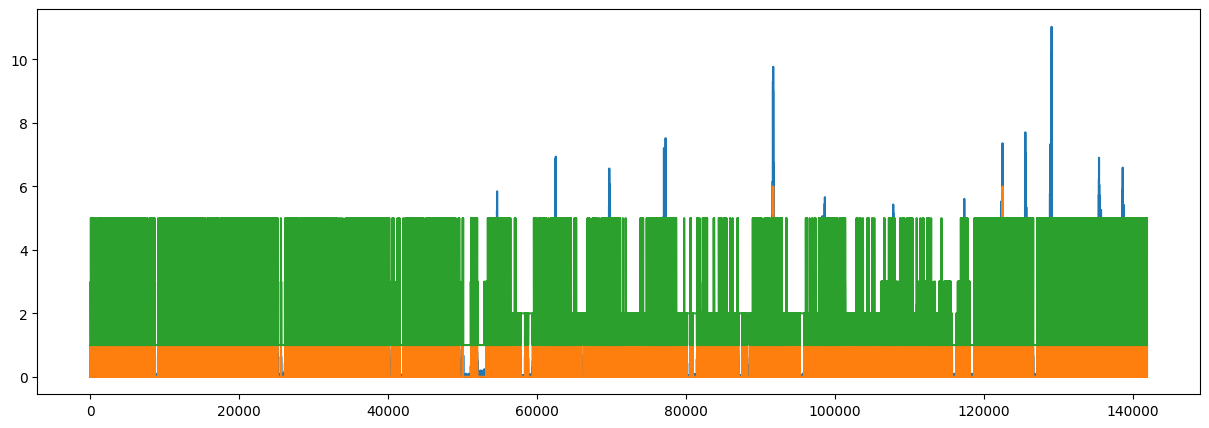

In [49]:
plt.figure(figsize=(15,5))
plt.plot(Y[:, -1])
plt.plot(Y[:, -2])
plt.plot(Y[:, -4])